In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchmetrics.functional.regression import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)


In [129]:
filename = "../DATA/HOME_전력거래_연료비용.xlsx"
priceDF = pd.read_excel(filename, header=1, usecols=[0, 11, 12, 13, 14, 15]).drop(0)
priceDF.columns = ["DATE", "NUC", "BIT", "ANTH", "OIL", "LNG"]
priceDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 1 to 277
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    277 non-null    object
 1   NUC     277 non-null    object
 2   BIT     277 non-null    object
 3   ANTH    277 non-null    object
 4   OIL     277 non-null    object
 5   LNG     277 non-null    object
dtypes: object(6)
memory usage: 13.1+ KB


c:\Users\KDP-25\.conda\envs\Torch_NLP38\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [130]:
priceDF = (
    priceDF.astype(
        {
            "NUC": "float64",
            "BIT": "float64",
            "ANTH": "float64",
            "OIL": "float64",
            "LNG": "float64",
        }
    )
    .sort_values("DATE")
    .reset_index(drop=True)
)
priceDF["SUM"] = priceDF.sum(axis=1, numeric_only=True)
priceDF.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    277 non-null    object 
 1   NUC     277 non-null    float64
 2   BIT     277 non-null    float64
 3   ANTH    277 non-null    float64
 4   OIL     277 non-null    float64
 5   LNG     277 non-null    float64
 6   SUM     277 non-null    float64
dtypes: float64(6), object(1)
memory usage: 15.3+ KB


In [131]:
price_sumDF = priceDF[["SUM"]].iloc[:-13]
price_sum_realDF = priceDF[["SUM"]].iloc[-13:].reset_index(drop=True)
price_sumDF.shape, price_sum_realDF.shape


((264, 1), (13, 1))

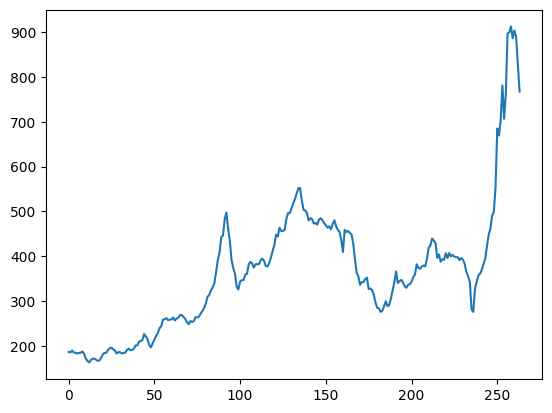

In [132]:
plt.plot(price_sumDF, label="SUM")
plt.show()


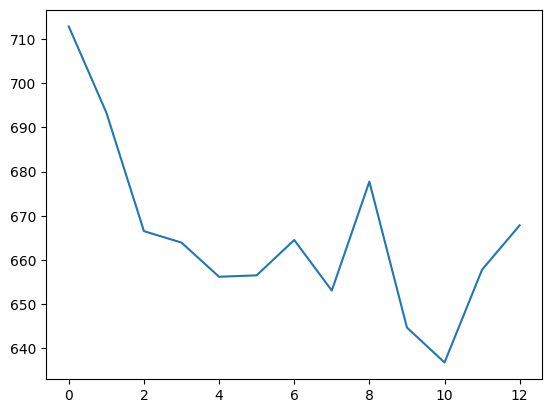

In [133]:
plt.plot(price_sum_realDF, label="SUM_REAL")
plt.show()


In [265]:
price_sumDF["SUM"]


0      186.087
1      184.848
2      189.255
3      184.739
4      184.323
        ...   
259    886.339
260    903.975
261    889.791
262    830.157
263    767.508
Name: SUM, Length: 264, dtype: float64

In [272]:
class FuelPriceDataset(Dataset):
    def __init__(self, data, step=3):
        data = data if isinstance(data, np.ndarray) else data.values
        self.max_data = np.max(data)
        self.min_data = np.min(data)
        self.data = (data - self.min_data) / (self.max_data - self.min_data)
        self.data = torch.FloatTensor(self.data)
        self.step = step

    def __len__(self):
        return len(self.data) - self.step

    def __getitem__(self, i):
        data = self.data[i : i + self.step]
        label = self.data[i + self.step]
        return data, label


In [278]:
class FuelPriceModel(nn.Module):
    def __init__(self, hidden_size, num_layers, step=3):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=step,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return torch.flatten(x)


In [359]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_size = 1024
num_layers = 2
step = 12
batch_size = 8

model = FuelPriceModel(hidden_size, num_layers, step).to(device)
dataset = FuelPriceDataset(price_sumDF["SUM"], step)
loader = DataLoader(dataset, batch_size)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

len(loader)


32

In [360]:
def learning(epochs, epoch, model, loader, optimizer, loss_fn, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    lossList, maeList, mseList, r2List = [], [], [], []
    with torch.set_grad_enabled(is_train):
        pbar = tqdm(loader, total=len(loader))
        for data, label in pbar:
            pred = model(data.to(device))
            loss = loss_fn(pred, label.to(device))
            lossList.append(loss.item())
            maeList.append(mean_absolute_error(pred, label.to(device)).item())
            mseList.append(mean_squared_error(pred, label.to(device)).item())
            r2List.append(r2_score(pred, label.to(device)).item())
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_description(
                    f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.6f}"
                )
    return np.mean(lossList), np.mean(maeList), np.mean(mseList), np.mean(r2List)


In [378]:
pre_r2 = 0
pre_loss = 1000


In [379]:
epochs = 1000
for epoch in range(epochs):
    loss, mae, mse, r2 = learning(
        epochs, epoch, model, loader, optimizer, loss_fn, is_train=True
    )
    if epoch % 10 == 9:
        print(
            f"  ==== Loss: {loss:.6f} | MAE: {mae:.6f} | MSE: {mse:.6f} | R2: {r2:.6f} ===="
        )
    if pre_r2 < r2 or (pre_r2 <= r2 and pre_loss > loss):
        torch.save(model, "fuel_price_model_r2.pth")
        pre_r2 = r2
        pre_loss = loss


Epoch: 0/1000 | Loss: 0.000122: 100%|██████████| 32/32 [00:02<00:00, 13.32it/s]
Epoch: 1/1000 | Loss: 0.000083: 100%|██████████| 32/32 [00:02<00:00, 13.89it/s]
Epoch: 2/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 13.56it/s]
Epoch: 3/1000 | Loss: 0.000037: 100%|██████████| 32/32 [00:02<00:00, 11.37it/s]
Epoch: 4/1000 | Loss: 0.000024: 100%|██████████| 32/32 [00:02<00:00, 12.82it/s]
Epoch: 5/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:02<00:00, 13.12it/s]
Epoch: 6/1000 | Loss: 0.000063: 100%|██████████| 32/32 [00:02<00:00, 13.02it/s]
Epoch: 7/1000 | Loss: 0.000034: 100%|██████████| 32/32 [00:02<00:00, 12.78it/s]
Epoch: 8/1000 | Loss: 0.000057: 100%|██████████| 32/32 [00:02<00:00, 12.65it/s]
Epoch: 9/1000 | Loss: 0.000335: 100%|██████████| 32/32 [00:03<00:00, 10.54it/s]


  ==== Loss: 0.000133 | MAE: 0.008336 | MSE: 0.000133 | R2: 0.045939 ====


Epoch: 10/1000 | Loss: 0.000590: 100%|██████████| 32/32 [00:02<00:00, 12.14it/s]
Epoch: 11/1000 | Loss: 0.000403: 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]
Epoch: 12/1000 | Loss: 0.000461: 100%|██████████| 32/32 [00:02<00:00, 12.32it/s]
Epoch: 13/1000 | Loss: 0.000357: 100%|██████████| 32/32 [00:02<00:00, 11.12it/s]
Epoch: 14/1000 | Loss: 0.001050: 100%|██████████| 32/32 [00:02<00:00, 12.99it/s]
Epoch: 15/1000 | Loss: 0.000832: 100%|██████████| 32/32 [00:02<00:00, 13.19it/s]
Epoch: 16/1000 | Loss: 0.000348: 100%|██████████| 32/32 [00:02<00:00, 12.85it/s]
Epoch: 17/1000 | Loss: 0.000260: 100%|██████████| 32/32 [00:02<00:00, 13.05it/s]
Epoch: 18/1000 | Loss: 0.000431: 100%|██████████| 32/32 [00:02<00:00, 12.54it/s]
Epoch: 19/1000 | Loss: 0.000335: 100%|██████████| 32/32 [00:02<00:00, 13.01it/s]


  ==== Loss: 0.000156 | MAE: 0.009824 | MSE: 0.000156 | R2: -0.158339 ====


Epoch: 20/1000 | Loss: 0.000159: 100%|██████████| 32/32 [00:02<00:00, 12.43it/s]
Epoch: 21/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:02<00:00, 12.69it/s]
Epoch: 22/1000 | Loss: 0.000035: 100%|██████████| 32/32 [00:02<00:00, 12.91it/s]
Epoch: 23/1000 | Loss: 0.000006: 100%|██████████| 32/32 [00:02<00:00, 12.48it/s]
Epoch: 24/1000 | Loss: 0.000094: 100%|██████████| 32/32 [00:02<00:00, 12.95it/s]
Epoch: 25/1000 | Loss: 0.000345: 100%|██████████| 32/32 [00:02<00:00, 12.63it/s]
Epoch: 26/1000 | Loss: 0.000140: 100%|██████████| 32/32 [00:02<00:00, 12.82it/s]
Epoch: 27/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 12.41it/s]
Epoch: 28/1000 | Loss: 0.000033: 100%|██████████| 32/32 [00:02<00:00, 12.20it/s]
Epoch: 29/1000 | Loss: 0.000080: 100%|██████████| 32/32 [00:02<00:00, 12.71it/s]


  ==== Loss: 0.000027 | MAE: 0.004039 | MSE: 0.000027 | R2: 0.663420 ====


Epoch: 30/1000 | Loss: 0.000020: 100%|██████████| 32/32 [00:02<00:00, 12.11it/s]
Epoch: 31/1000 | Loss: 0.000021: 100%|██████████| 32/32 [00:02<00:00, 11.98it/s]
Epoch: 32/1000 | Loss: 0.000036: 100%|██████████| 32/32 [00:02<00:00, 11.95it/s]
Epoch: 33/1000 | Loss: 0.000051: 100%|██████████| 32/32 [00:02<00:00, 11.44it/s]
Epoch: 34/1000 | Loss: 0.000038: 100%|██████████| 32/32 [00:02<00:00, 12.06it/s]
Epoch: 35/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:02<00:00, 12.07it/s]
Epoch: 36/1000 | Loss: 0.000031: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s]
Epoch: 37/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 11.38it/s]
Epoch: 38/1000 | Loss: 0.000006: 100%|██████████| 32/32 [00:02<00:00, 11.62it/s]
Epoch: 39/1000 | Loss: 0.000041: 100%|██████████| 32/32 [00:02<00:00, 11.38it/s]


  ==== Loss: 0.000014 | MAE: 0.002910 | MSE: 0.000014 | R2: 0.832772 ====


Epoch: 40/1000 | Loss: 0.000097: 100%|██████████| 32/32 [00:02<00:00, 10.93it/s]
Epoch: 41/1000 | Loss: 0.000015: 100%|██████████| 32/32 [00:02<00:00, 11.44it/s]
Epoch: 42/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:02<00:00, 11.31it/s]
Epoch: 43/1000 | Loss: 0.000034: 100%|██████████| 32/32 [00:02<00:00, 11.69it/s]
Epoch: 44/1000 | Loss: 0.000013: 100%|██████████| 32/32 [00:02<00:00, 11.15it/s]
Epoch: 45/1000 | Loss: 0.000046: 100%|██████████| 32/32 [00:02<00:00, 11.54it/s]
Epoch: 46/1000 | Loss: 0.000116: 100%|██████████| 32/32 [00:02<00:00, 10.99it/s]
Epoch: 47/1000 | Loss: 0.000077: 100%|██████████| 32/32 [00:03<00:00, 10.43it/s]
Epoch: 48/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00, 10.43it/s]
Epoch: 49/1000 | Loss: 0.000051: 100%|██████████| 32/32 [00:02<00:00, 10.80it/s]


  ==== Loss: 0.000034 | MAE: 0.004686 | MSE: 0.000034 | R2: 0.602407 ====


Epoch: 50/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:03<00:00, 10.21it/s]
Epoch: 51/1000 | Loss: 0.000068: 100%|██████████| 32/32 [00:03<00:00,  9.98it/s]
Epoch: 52/1000 | Loss: 0.000274: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s]
Epoch: 53/1000 | Loss: 0.000175: 100%|██████████| 32/32 [00:03<00:00,  9.63it/s]
Epoch: 54/1000 | Loss: 0.000029: 100%|██████████| 32/32 [00:03<00:00,  8.87it/s]
Epoch: 55/1000 | Loss: 0.000018: 100%|██████████| 32/32 [00:03<00:00,  9.54it/s]
Epoch: 56/1000 | Loss: 0.000033: 100%|██████████| 32/32 [00:03<00:00,  9.29it/s]
Epoch: 57/1000 | Loss: 0.000132: 100%|██████████| 32/32 [00:03<00:00,  8.53it/s]
Epoch: 58/1000 | Loss: 0.000086: 100%|██████████| 32/32 [00:03<00:00,  8.27it/s]
Epoch: 59/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:04<00:00,  7.29it/s]


  ==== Loss: 0.000074 | MAE: 0.007068 | MSE: 0.000074 | R2: 0.492125 ====


Epoch: 60/1000 | Loss: 0.000025: 100%|██████████| 32/32 [00:03<00:00,  8.21it/s]
Epoch: 61/1000 | Loss: 0.000161: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]
Epoch: 62/1000 | Loss: 0.001166: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]
Epoch: 63/1000 | Loss: 0.000922: 100%|██████████| 32/32 [00:03<00:00,  8.10it/s]
Epoch: 64/1000 | Loss: 0.000169: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s]
Epoch: 65/1000 | Loss: 0.000027: 100%|██████████| 32/32 [00:04<00:00,  7.93it/s]
Epoch: 66/1000 | Loss: 0.000108: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s]
Epoch: 67/1000 | Loss: 0.000535: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s]
Epoch: 68/1000 | Loss: 0.000860: 100%|██████████| 32/32 [00:03<00:00,  9.41it/s]
Epoch: 69/1000 | Loss: 0.000281: 100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


  ==== Loss: 0.000201 | MAE: 0.011292 | MSE: 0.000201 | R2: -0.346436 ====


Epoch: 70/1000 | Loss: 0.000072: 100%|██████████| 32/32 [00:03<00:00, 10.57it/s]
Epoch: 71/1000 | Loss: 0.000274: 100%|██████████| 32/32 [00:02<00:00, 11.36it/s]
Epoch: 72/1000 | Loss: 0.000326: 100%|██████████| 32/32 [00:02<00:00, 11.07it/s]
Epoch: 73/1000 | Loss: 0.000101: 100%|██████████| 32/32 [00:02<00:00, 11.58it/s]
Epoch: 74/1000 | Loss: 0.000021: 100%|██████████| 32/32 [00:02<00:00, 11.26it/s]
Epoch: 75/1000 | Loss: 0.000102: 100%|██████████| 32/32 [00:02<00:00, 11.56it/s]
Epoch: 76/1000 | Loss: 0.000345: 100%|██████████| 32/32 [00:02<00:00, 11.45it/s]
Epoch: 77/1000 | Loss: 0.000241: 100%|██████████| 32/32 [00:03<00:00, 10.57it/s]
Epoch: 78/1000 | Loss: 0.000181: 100%|██████████| 32/32 [00:02<00:00, 11.72it/s]
Epoch: 79/1000 | Loss: 0.000022: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s]


  ==== Loss: 0.000034 | MAE: 0.004931 | MSE: 0.000034 | R2: 0.664983 ====


Epoch: 80/1000 | Loss: 0.000023: 100%|██████████| 32/32 [00:02<00:00, 11.59it/s]
Epoch: 81/1000 | Loss: 0.000076: 100%|██████████| 32/32 [00:02<00:00, 11.83it/s]
Epoch: 82/1000 | Loss: 0.000183: 100%|██████████| 32/32 [00:02<00:00, 11.52it/s]
Epoch: 83/1000 | Loss: 0.000252: 100%|██████████| 32/32 [00:02<00:00, 12.36it/s]
Epoch: 84/1000 | Loss: 0.000071: 100%|██████████| 32/32 [00:02<00:00, 11.34it/s]
Epoch: 85/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]
Epoch: 86/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:02<00:00, 11.77it/s]
Epoch: 87/1000 | Loss: 0.000097: 100%|██████████| 32/32 [00:02<00:00, 11.23it/s]
Epoch: 88/1000 | Loss: 0.000117: 100%|██████████| 32/32 [00:02<00:00, 11.57it/s]
Epoch: 89/1000 | Loss: 0.000086: 100%|██████████| 32/32 [00:02<00:00, 11.04it/s]


  ==== Loss: 0.000029 | MAE: 0.004157 | MSE: 0.000029 | R2: 0.847817 ====


Epoch: 90/1000 | Loss: 0.000034: 100%|██████████| 32/32 [00:02<00:00, 10.97it/s]
Epoch: 91/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 10.96it/s]
Epoch: 92/1000 | Loss: 0.000023: 100%|██████████| 32/32 [00:02<00:00, 11.56it/s]
Epoch: 93/1000 | Loss: 0.000039: 100%|██████████| 32/32 [00:02<00:00, 11.01it/s]
Epoch: 94/1000 | Loss: 0.000051: 100%|██████████| 32/32 [00:03<00:00, 10.23it/s]
Epoch: 95/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:02<00:00, 10.96it/s]
Epoch: 96/1000 | Loss: 0.000022: 100%|██████████| 32/32 [00:03<00:00, 10.54it/s]
Epoch: 97/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:03<00:00, 10.44it/s]
Epoch: 98/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s]
Epoch: 99/1000 | Loss: 0.000040: 100%|██████████| 32/32 [00:03<00:00, 10.39it/s]


  ==== Loss: 0.000014 | MAE: 0.002733 | MSE: 0.000014 | R2: 0.934422 ====


Epoch: 100/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00,  9.58it/s]
Epoch: 101/1000 | Loss: 0.000046: 100%|██████████| 32/32 [00:03<00:00, 10.17it/s]
Epoch: 102/1000 | Loss: 0.000048: 100%|██████████| 32/32 [00:03<00:00,  9.87it/s]
Epoch: 103/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00,  9.62it/s]
Epoch: 104/1000 | Loss: 0.000087: 100%|██████████| 32/32 [00:03<00:00,  9.58it/s]
Epoch: 105/1000 | Loss: 0.000122: 100%|██████████| 32/32 [00:03<00:00,  9.20it/s]
Epoch: 106/1000 | Loss: 0.000147: 100%|██████████| 32/32 [00:03<00:00,  8.86it/s]
Epoch: 107/1000 | Loss: 0.000232: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s]
Epoch: 108/1000 | Loss: 0.000167: 100%|██████████| 32/32 [00:03<00:00,  8.54it/s]
Epoch: 109/1000 | Loss: 0.000490: 100%|██████████| 32/32 [00:03<00:00,  8.47it/s]


  ==== Loss: 0.000104 | MAE: 0.007581 | MSE: 0.000104 | R2: 0.570843 ====


Epoch: 110/1000 | Loss: 0.000406: 100%|██████████| 32/32 [00:03<00:00,  8.30it/s]
Epoch: 111/1000 | Loss: 0.000597: 100%|██████████| 32/32 [00:03<00:00,  8.45it/s]
Epoch: 112/1000 | Loss: 0.000622: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s]
Epoch: 113/1000 | Loss: 0.000547: 100%|██████████| 32/32 [00:03<00:00, 10.13it/s]
Epoch: 114/1000 | Loss: 0.000488: 100%|██████████| 32/32 [00:03<00:00,  9.65it/s]
Epoch: 115/1000 | Loss: 0.000386: 100%|██████████| 32/32 [00:03<00:00, 10.28it/s]
Epoch: 116/1000 | Loss: 0.000096: 100%|██████████| 32/32 [00:02<00:00, 10.82it/s]
Epoch: 117/1000 | Loss: 0.000076: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s]
Epoch: 118/1000 | Loss: 0.000057: 100%|██████████| 32/32 [00:02<00:00, 11.25it/s]
Epoch: 119/1000 | Loss: 0.000082: 100%|██████████| 32/32 [00:02<00:00, 10.92it/s]


  ==== Loss: 0.000032 | MAE: 0.004218 | MSE: 0.000032 | R2: 0.818371 ====


Epoch: 120/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:02<00:00, 11.31it/s]
Epoch: 121/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.04it/s]
Epoch: 122/1000 | Loss: 0.000027: 100%|██████████| 32/32 [00:02<00:00, 11.85it/s]
Epoch: 123/1000 | Loss: 0.000077: 100%|██████████| 32/32 [00:02<00:00, 11.41it/s]
Epoch: 124/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:02<00:00, 11.78it/s]
Epoch: 125/1000 | Loss: 0.000035: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s]
Epoch: 126/1000 | Loss: 0.000094: 100%|██████████| 32/32 [00:02<00:00, 11.89it/s]
Epoch: 127/1000 | Loss: 0.000065: 100%|██████████| 32/32 [00:02<00:00, 12.10it/s]
Epoch: 128/1000 | Loss: 0.000026: 100%|██████████| 32/32 [00:02<00:00, 11.75it/s]
Epoch: 129/1000 | Loss: 0.000088: 100%|██████████| 32/32 [00:02<00:00, 12.37it/s]


  ==== Loss: 0.000056 | MAE: 0.006146 | MSE: 0.000056 | R2: 0.215727 ====


Epoch: 130/1000 | Loss: 0.000045: 100%|██████████| 32/32 [00:02<00:00, 10.99it/s]
Epoch: 131/1000 | Loss: 0.000024: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]
Epoch: 132/1000 | Loss: 0.000101: 100%|██████████| 32/32 [00:02<00:00, 11.58it/s]
Epoch: 133/1000 | Loss: 0.000091: 100%|██████████| 32/32 [00:02<00:00, 11.26it/s]
Epoch: 134/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.66it/s]
Epoch: 135/1000 | Loss: 0.000259: 100%|██████████| 32/32 [00:02<00:00, 11.16it/s]
Epoch: 136/1000 | Loss: 0.000350: 100%|██████████| 32/32 [00:02<00:00, 11.12it/s]
Epoch: 137/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00, 10.58it/s]
Epoch: 138/1000 | Loss: 0.000253: 100%|██████████| 32/32 [00:02<00:00, 10.91it/s]
Epoch: 139/1000 | Loss: 0.000517: 100%|██████████| 32/32 [00:02<00:00, 11.34it/s]


  ==== Loss: 0.000230 | MAE: 0.011841 | MSE: 0.000230 | R2: -0.792305 ====


Epoch: 140/1000 | Loss: 0.000132: 100%|██████████| 32/32 [00:03<00:00, 10.26it/s]
Epoch: 141/1000 | Loss: 0.000096: 100%|██████████| 32/32 [00:02<00:00, 11.09it/s]
Epoch: 142/1000 | Loss: 0.000207: 100%|██████████| 32/32 [00:03<00:00, 10.63it/s]
Epoch: 143/1000 | Loss: 0.000153: 100%|██████████| 32/32 [00:03<00:00, 10.51it/s]
Epoch: 144/1000 | Loss: 0.000057: 100%|██████████| 32/32 [00:03<00:00, 10.27it/s]
Epoch: 145/1000 | Loss: 0.000736: 100%|██████████| 32/32 [00:03<00:00, 10.32it/s]
Epoch: 146/1000 | Loss: 0.000388: 100%|██████████| 32/32 [00:03<00:00,  9.53it/s]
Epoch: 147/1000 | Loss: 0.000164: 100%|██████████| 32/32 [00:03<00:00,  9.69it/s]
Epoch: 148/1000 | Loss: 0.000112: 100%|██████████| 32/32 [00:03<00:00,  9.96it/s]
Epoch: 149/1000 | Loss: 0.000030: 100%|██████████| 32/32 [00:03<00:00,  8.16it/s]


  ==== Loss: 0.000057 | MAE: 0.006159 | MSE: 0.000057 | R2: 0.366847 ====


Epoch: 150/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:04<00:00,  7.97it/s]
Epoch: 151/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  8.97it/s]
Epoch: 152/1000 | Loss: 0.000284: 100%|██████████| 32/32 [00:03<00:00,  8.43it/s]
Epoch: 153/1000 | Loss: 0.000603: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
Epoch: 154/1000 | Loss: 0.000188: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]
Epoch: 155/1000 | Loss: 0.000090: 100%|██████████| 32/32 [00:03<00:00,  8.05it/s]
Epoch: 156/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:03<00:00,  8.46it/s]
Epoch: 157/1000 | Loss: 0.000055: 100%|██████████| 32/32 [00:03<00:00,  9.03it/s]
Epoch: 158/1000 | Loss: 0.000145: 100%|██████████| 32/32 [00:03<00:00,  9.03it/s]
Epoch: 159/1000 | Loss: 0.000145: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s]


  ==== Loss: 0.000062 | MAE: 0.005691 | MSE: 0.000062 | R2: 0.487835 ====


Epoch: 160/1000 | Loss: 0.000260: 100%|██████████| 32/32 [00:03<00:00,  9.83it/s]
Epoch: 161/1000 | Loss: 0.000139: 100%|██████████| 32/32 [00:03<00:00, 10.00it/s]
Epoch: 162/1000 | Loss: 0.000013: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]
Epoch: 163/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:02<00:00, 10.73it/s]
Epoch: 164/1000 | Loss: 0.000100: 100%|██████████| 32/32 [00:02<00:00, 10.98it/s]
Epoch: 165/1000 | Loss: 0.000331: 100%|██████████| 32/32 [00:02<00:00, 11.05it/s]
Epoch: 166/1000 | Loss: 0.000196: 100%|██████████| 32/32 [00:03<00:00,  9.43it/s]
Epoch: 167/1000 | Loss: 0.000053: 100%|██████████| 32/32 [00:02<00:00, 11.22it/s]
Epoch: 168/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 10.88it/s]
Epoch: 169/1000 | Loss: 0.000053: 100%|██████████| 32/32 [00:03<00:00, 10.15it/s]


  ==== Loss: 0.000021 | MAE: 0.003732 | MSE: 0.000021 | R2: 0.777308 ====


Epoch: 170/1000 | Loss: 0.000159: 100%|██████████| 32/32 [00:03<00:00, 10.26it/s]
Epoch: 171/1000 | Loss: 0.000135: 100%|██████████| 32/32 [00:02<00:00, 10.97it/s]
Epoch: 172/1000 | Loss: 0.000094: 100%|██████████| 32/32 [00:02<00:00, 11.36it/s]
Epoch: 173/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]
Epoch: 174/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:02<00:00, 11.80it/s]
Epoch: 175/1000 | Loss: 0.000055: 100%|██████████| 32/32 [00:02<00:00, 11.38it/s]
Epoch: 176/1000 | Loss: 0.000096: 100%|██████████| 32/32 [00:02<00:00, 11.52it/s]
Epoch: 177/1000 | Loss: 0.000084: 100%|██████████| 32/32 [00:02<00:00, 11.22it/s]
Epoch: 178/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:02<00:00, 10.88it/s]
Epoch: 179/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:02<00:00, 11.58it/s]


  ==== Loss: 0.000014 | MAE: 0.003062 | MSE: 0.000014 | R2: 0.929148 ====


Epoch: 180/1000 | Loss: 0.000026: 100%|██████████| 32/32 [00:03<00:00, 10.51it/s]
Epoch: 181/1000 | Loss: 0.000035: 100%|██████████| 32/32 [00:02<00:00, 11.13it/s]
Epoch: 182/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 10.75it/s]
Epoch: 183/1000 | Loss: 0.000031: 100%|██████████| 32/32 [00:02<00:00, 11.03it/s]
Epoch: 184/1000 | Loss: 0.000057: 100%|██████████| 32/32 [00:03<00:00, 10.33it/s]
Epoch: 185/1000 | Loss: 0.000039: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s]
Epoch: 186/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]
Epoch: 187/1000 | Loss: 0.000034: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s]
Epoch: 188/1000 | Loss: 0.000023: 100%|██████████| 32/32 [00:03<00:00, 10.05it/s]
Epoch: 189/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  9.96it/s]


  ==== Loss: 0.000011 | MAE: 0.002618 | MSE: 0.000011 | R2: 0.969720 ====


Epoch: 190/1000 | Loss: 0.000039: 100%|██████████| 32/32 [00:03<00:00,  9.31it/s]
Epoch: 191/1000 | Loss: 0.000092: 100%|██████████| 32/32 [00:03<00:00,  9.77it/s]
Epoch: 192/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00,  9.53it/s]
Epoch: 193/1000 | Loss: 0.000072: 100%|██████████| 32/32 [00:03<00:00,  9.92it/s]
Epoch: 194/1000 | Loss: 0.000175: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s]
Epoch: 195/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:03<00:00,  8.74it/s]
Epoch: 196/1000 | Loss: 0.000248: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s]
Epoch: 197/1000 | Loss: 0.000443: 100%|██████████| 32/32 [00:04<00:00,  7.40it/s]
Epoch: 198/1000 | Loss: 0.000127: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]
Epoch: 199/1000 | Loss: 0.000076: 100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


  ==== Loss: 0.000160 | MAE: 0.010120 | MSE: 0.000160 | R2: -0.518845 ====


Epoch: 200/1000 | Loss: 0.000049: 100%|██████████| 32/32 [00:04<00:00,  7.21it/s]
Epoch: 201/1000 | Loss: 0.001124: 100%|██████████| 32/32 [00:04<00:00,  7.98it/s]
Epoch: 202/1000 | Loss: 0.000999: 100%|██████████| 32/32 [00:03<00:00,  8.73it/s]
Epoch: 203/1000 | Loss: 0.001157: 100%|██████████| 32/32 [00:03<00:00,  9.56it/s]
Epoch: 204/1000 | Loss: 0.000528: 100%|██████████| 32/32 [00:03<00:00,  9.02it/s]
Epoch: 205/1000 | Loss: 0.000711: 100%|██████████| 32/32 [00:03<00:00,  9.56it/s]
Epoch: 206/1000 | Loss: 0.001095: 100%|██████████| 32/32 [00:03<00:00, 10.06it/s]
Epoch: 207/1000 | Loss: 0.000807: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s]
Epoch: 208/1000 | Loss: 0.000593: 100%|██████████| 32/32 [00:02<00:00, 10.84it/s]
Epoch: 209/1000 | Loss: 0.000199: 100%|██████████| 32/32 [00:03<00:00, 10.56it/s]


  ==== Loss: 0.000096 | MAE: 0.007999 | MSE: 0.000096 | R2: -0.090315 ====


Epoch: 210/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  9.87it/s]
Epoch: 211/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:02<00:00, 10.86it/s]
Epoch: 212/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00, 10.42it/s]
Epoch: 213/1000 | Loss: 0.000026: 100%|██████████| 32/32 [00:02<00:00, 11.43it/s]
Epoch: 214/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.54it/s]
Epoch: 215/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00, 10.54it/s]
Epoch: 216/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 10.97it/s]
Epoch: 217/1000 | Loss: 0.000024: 100%|██████████| 32/32 [00:02<00:00, 10.94it/s]
Epoch: 218/1000 | Loss: 0.000013: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s]
Epoch: 219/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:02<00:00, 11.84it/s]


  ==== Loss: 0.000008 | MAE: 0.002239 | MSE: 0.000008 | R2: 0.978821 ====


Epoch: 220/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.33it/s]
Epoch: 221/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.36it/s]
Epoch: 222/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:02<00:00, 10.73it/s]
Epoch: 223/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.14it/s]
Epoch: 224/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:03<00:00, 10.64it/s]
Epoch: 225/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s]
Epoch: 226/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:03<00:00, 10.33it/s]
Epoch: 227/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00, 10.35it/s]
Epoch: 228/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00, 10.57it/s]
Epoch: 229/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  9.98it/s]


  ==== Loss: 0.000004 | MAE: 0.001586 | MSE: 0.000004 | R2: 1.000000 ====


Epoch: 230/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:03<00:00,  9.72it/s]
Epoch: 231/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00, 10.13it/s]
Epoch: 232/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  9.33it/s]
Epoch: 233/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:03<00:00,  9.92it/s]
Epoch: 234/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s]
Epoch: 235/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.41it/s]
Epoch: 236/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:03<00:00,  8.87it/s]
Epoch: 237/1000 | Loss: 0.000053: 100%|██████████| 32/32 [00:03<00:00,  8.97it/s]
Epoch: 238/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00,  8.74it/s]
Epoch: 239/1000 | Loss: 0.000018: 100%|██████████| 32/32 [00:03<00:00,  8.23it/s]


  ==== Loss: 0.000020 | MAE: 0.003789 | MSE: 0.000020 | R2: 0.858107 ====


Epoch: 240/1000 | Loss: 0.000058: 100%|██████████| 32/32 [00:04<00:00,  7.54it/s]
Epoch: 241/1000 | Loss: 0.000028: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s]
Epoch: 242/1000 | Loss: 0.000054: 100%|██████████| 32/32 [00:04<00:00,  7.99it/s]
Epoch: 243/1000 | Loss: 0.000093: 100%|██████████| 32/32 [00:04<00:00,  7.93it/s]
Epoch: 244/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s]
Epoch: 245/1000 | Loss: 0.000254: 100%|██████████| 32/32 [00:03<00:00,  9.16it/s]
Epoch: 246/1000 | Loss: 0.000498: 100%|██████████| 32/32 [00:03<00:00,  9.52it/s]
Epoch: 247/1000 | Loss: 0.000126: 100%|██████████| 32/32 [00:03<00:00, 10.63it/s]
Epoch: 248/1000 | Loss: 0.000051: 100%|██████████| 32/32 [00:03<00:00, 10.03it/s]
Epoch: 249/1000 | Loss: 0.000036: 100%|██████████| 32/32 [00:02<00:00, 10.81it/s]


  ==== Loss: 0.000070 | MAE: 0.006609 | MSE: 0.000070 | R2: -0.124249 ====


Epoch: 250/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:03<00:00, 10.58it/s]
Epoch: 251/1000 | Loss: 0.000224: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s]
Epoch: 252/1000 | Loss: 0.000177: 100%|██████████| 32/32 [00:02<00:00, 11.07it/s]
Epoch: 253/1000 | Loss: 0.000058: 100%|██████████| 32/32 [00:02<00:00, 11.16it/s]
Epoch: 254/1000 | Loss: 0.000217: 100%|██████████| 32/32 [00:02<00:00, 11.85it/s]
Epoch: 255/1000 | Loss: 0.000426: 100%|██████████| 32/32 [00:02<00:00, 11.35it/s]
Epoch: 256/1000 | Loss: 0.000236: 100%|██████████| 32/32 [00:02<00:00, 12.07it/s]
Epoch: 257/1000 | Loss: 0.000112: 100%|██████████| 32/32 [00:02<00:00, 11.39it/s]
Epoch: 258/1000 | Loss: 0.000039: 100%|██████████| 32/32 [00:02<00:00, 10.97it/s]
Epoch: 259/1000 | Loss: 0.000148: 100%|██████████| 32/32 [00:02<00:00, 11.89it/s]


  ==== Loss: 0.000053 | MAE: 0.005569 | MSE: 0.000053 | R2: 0.257321 ====


Epoch: 260/1000 | Loss: 0.000093: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s]
Epoch: 261/1000 | Loss: 0.000031: 100%|██████████| 32/32 [00:02<00:00, 11.92it/s]
Epoch: 262/1000 | Loss: 0.000311: 100%|██████████| 32/32 [00:02<00:00, 10.76it/s]
Epoch: 263/1000 | Loss: 0.000311: 100%|██████████| 32/32 [00:02<00:00, 11.69it/s]
Epoch: 264/1000 | Loss: 0.000080: 100%|██████████| 32/32 [00:02<00:00, 10.84it/s]
Epoch: 265/1000 | Loss: 0.000006: 100%|██████████| 32/32 [00:02<00:00, 10.95it/s]
Epoch: 266/1000 | Loss: 0.000192: 100%|██████████| 32/32 [00:02<00:00, 10.87it/s]
Epoch: 267/1000 | Loss: 0.000420: 100%|██████████| 32/32 [00:03<00:00, 10.55it/s]
Epoch: 268/1000 | Loss: 0.000213: 100%|██████████| 32/32 [00:02<00:00, 10.80it/s]
Epoch: 269/1000 | Loss: 0.000048: 100%|██████████| 32/32 [00:03<00:00, 10.30it/s]


  ==== Loss: 0.000060 | MAE: 0.006265 | MSE: 0.000060 | R2: 0.582813 ====


Epoch: 270/1000 | Loss: 0.000104: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s]
Epoch: 271/1000 | Loss: 0.000238: 100%|██████████| 32/32 [00:03<00:00, 10.54it/s]
Epoch: 272/1000 | Loss: 0.000169: 100%|██████████| 32/32 [00:03<00:00,  9.74it/s]
Epoch: 273/1000 | Loss: 0.000066: 100%|██████████| 32/32 [00:03<00:00, 10.47it/s]
Epoch: 274/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:03<00:00,  9.40it/s]
Epoch: 275/1000 | Loss: 0.000159: 100%|██████████| 32/32 [00:03<00:00, 10.08it/s]
Epoch: 276/1000 | Loss: 0.000161: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s]
Epoch: 277/1000 | Loss: 0.000056: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s]
Epoch: 278/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:03<00:00,  9.30it/s]
Epoch: 279/1000 | Loss: 0.000055: 100%|██████████| 32/32 [00:03<00:00,  8.40it/s]


  ==== Loss: 0.000023 | MAE: 0.003626 | MSE: 0.000023 | R2: 0.667138 ====


Epoch: 280/1000 | Loss: 0.000050: 100%|██████████| 32/32 [00:03<00:00,  8.33it/s]
Epoch: 281/1000 | Loss: 0.000025: 100%|██████████| 32/32 [00:04<00:00,  7.94it/s]
Epoch: 282/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  8.05it/s]
Epoch: 283/1000 | Loss: 0.000026: 100%|██████████| 32/32 [00:04<00:00,  7.93it/s]
Epoch: 284/1000 | Loss: 0.000035: 100%|██████████| 32/32 [00:03<00:00,  8.15it/s]
Epoch: 285/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00,  8.24it/s]
Epoch: 286/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s]
Epoch: 287/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00,  9.63it/s]
Epoch: 288/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.50it/s]
Epoch: 289/1000 | Loss: 0.000027: 100%|██████████| 32/32 [00:03<00:00, 10.28it/s]


  ==== Loss: 0.000024 | MAE: 0.003841 | MSE: 0.000024 | R2: 0.813523 ====


Epoch: 290/1000 | Loss: 0.000059: 100%|██████████| 32/32 [00:03<00:00,  9.78it/s]
Epoch: 291/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.43it/s]
Epoch: 292/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:02<00:00, 11.35it/s]
Epoch: 293/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:03<00:00,  9.97it/s]
Epoch: 294/1000 | Loss: 0.000191: 100%|██████████| 32/32 [00:03<00:00,  9.67it/s]
Epoch: 295/1000 | Loss: 0.000924: 100%|██████████| 32/32 [00:03<00:00,  8.72it/s]
Epoch: 296/1000 | Loss: 0.001256: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]
Epoch: 297/1000 | Loss: 0.001327: 100%|██████████| 32/32 [00:02<00:00, 11.79it/s]
Epoch: 298/1000 | Loss: 0.001197: 100%|██████████| 32/32 [00:02<00:00, 11.27it/s]
Epoch: 299/1000 | Loss: 0.001799: 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]


  ==== Loss: 0.000250 | MAE: 0.011461 | MSE: 0.000250 | R2: -0.456711 ====


Epoch: 300/1000 | Loss: 0.000652: 100%|██████████| 32/32 [00:02<00:00, 11.13it/s]
Epoch: 301/1000 | Loss: 0.000328: 100%|██████████| 32/32 [00:02<00:00, 12.24it/s]
Epoch: 302/1000 | Loss: 0.000291: 100%|██████████| 32/32 [00:02<00:00, 11.24it/s]
Epoch: 303/1000 | Loss: 0.000071: 100%|██████████| 32/32 [00:02<00:00, 11.77it/s]
Epoch: 304/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:02<00:00, 11.09it/s]
Epoch: 305/1000 | Loss: 0.000052: 100%|██████████| 32/32 [00:02<00:00, 11.12it/s]
Epoch: 306/1000 | Loss: 0.000020: 100%|██████████| 32/32 [00:02<00:00, 10.80it/s]
Epoch: 307/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:03<00:00, 10.06it/s]
Epoch: 308/1000 | Loss: 0.000037: 100%|██████████| 32/32 [00:02<00:00, 11.42it/s]
Epoch: 309/1000 | Loss: 0.000148: 100%|██████████| 32/32 [00:03<00:00, 10.58it/s]


  ==== Loss: 0.000031 | MAE: 0.004300 | MSE: 0.000031 | R2: 0.747490 ====


Epoch: 310/1000 | Loss: 0.000163: 100%|██████████| 32/32 [00:02<00:00, 10.70it/s]
Epoch: 311/1000 | Loss: 0.000064: 100%|██████████| 32/32 [00:02<00:00, 10.73it/s]
Epoch: 312/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:03<00:00,  8.27it/s]
Epoch: 313/1000 | Loss: 0.000051: 100%|██████████| 32/32 [00:03<00:00,  9.81it/s]
Epoch: 314/1000 | Loss: 0.000217: 100%|██████████| 32/32 [00:03<00:00, 10.01it/s]
Epoch: 315/1000 | Loss: 0.000178: 100%|██████████| 32/32 [00:03<00:00,  8.99it/s]
Epoch: 316/1000 | Loss: 0.000111: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s]
Epoch: 317/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  8.99it/s]
Epoch: 318/1000 | Loss: 0.000049: 100%|██████████| 32/32 [00:03<00:00,  9.55it/s]
Epoch: 319/1000 | Loss: 0.000069: 100%|██████████| 32/32 [00:03<00:00,  9.30it/s]


  ==== Loss: 0.000023 | MAE: 0.003365 | MSE: 0.000023 | R2: 0.806988 ====


Epoch: 320/1000 | Loss: 0.000086: 100%|██████████| 32/32 [00:03<00:00,  8.78it/s]
Epoch: 321/1000 | Loss: 0.000057: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s]
Epoch: 322/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  8.66it/s]
Epoch: 323/1000 | Loss: 0.000054: 100%|██████████| 32/32 [00:03<00:00,  8.15it/s]
Epoch: 324/1000 | Loss: 0.000094: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]
Epoch: 325/1000 | Loss: 0.000088: 100%|██████████| 32/32 [00:04<00:00,  7.97it/s]
Epoch: 326/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:04<00:00,  7.57it/s]
Epoch: 327/1000 | Loss: 0.000063: 100%|██████████| 32/32 [00:04<00:00,  7.91it/s]
Epoch: 328/1000 | Loss: 0.000163: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s]
Epoch: 329/1000 | Loss: 0.000168: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


  ==== Loss: 0.000042 | MAE: 0.005096 | MSE: 0.000042 | R2: 0.649793 ====


Epoch: 330/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  8.10it/s]
Epoch: 331/1000 | Loss: 0.000045: 100%|██████████| 32/32 [00:03<00:00,  8.26it/s]
Epoch: 332/1000 | Loss: 0.000069: 100%|██████████| 32/32 [00:03<00:00,  9.58it/s]
Epoch: 333/1000 | Loss: 0.000051: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s]
Epoch: 334/1000 | Loss: 0.000060: 100%|██████████| 32/32 [00:02<00:00, 10.75it/s]
Epoch: 335/1000 | Loss: 0.000367: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s]
Epoch: 336/1000 | Loss: 0.000296: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s]
Epoch: 337/1000 | Loss: 0.000078: 100%|██████████| 32/32 [00:02<00:00, 11.01it/s]
Epoch: 338/1000 | Loss: 0.000337: 100%|██████████| 32/32 [00:02<00:00, 11.51it/s]
Epoch: 339/1000 | Loss: 0.000360: 100%|██████████| 32/32 [00:02<00:00, 11.28it/s]


  ==== Loss: 0.000132 | MAE: 0.008865 | MSE: 0.000132 | R2: -0.578746 ====


Epoch: 340/1000 | Loss: 0.000173: 100%|██████████| 32/32 [00:02<00:00, 11.37it/s]
Epoch: 341/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s]
Epoch: 342/1000 | Loss: 0.000189: 100%|██████████| 32/32 [00:02<00:00, 11.02it/s]
Epoch: 343/1000 | Loss: 0.000330: 100%|██████████| 32/32 [00:02<00:00, 11.63it/s]
Epoch: 344/1000 | Loss: 0.000238: 100%|██████████| 32/32 [00:02<00:00, 12.07it/s]
Epoch: 345/1000 | Loss: 0.000037: 100%|██████████| 32/32 [00:02<00:00, 11.09it/s]
Epoch: 346/1000 | Loss: 0.000113: 100%|██████████| 32/32 [00:02<00:00, 11.71it/s]
Epoch: 347/1000 | Loss: 0.000375: 100%|██████████| 32/32 [00:02<00:00, 11.77it/s]
Epoch: 348/1000 | Loss: 0.000589: 100%|██████████| 32/32 [00:02<00:00, 11.42it/s]
Epoch: 349/1000 | Loss: 0.000351: 100%|██████████| 32/32 [00:02<00:00, 11.65it/s]


  ==== Loss: 0.000088 | MAE: 0.007315 | MSE: 0.000088 | R2: 0.396694 ====


Epoch: 350/1000 | Loss: 0.000083: 100%|██████████| 32/32 [00:02<00:00, 10.79it/s]
Epoch: 351/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 11.62it/s]
Epoch: 352/1000 | Loss: 0.000160: 100%|██████████| 32/32 [00:02<00:00, 11.20it/s]
Epoch: 353/1000 | Loss: 0.000539: 100%|██████████| 32/32 [00:02<00:00, 10.72it/s]
Epoch: 354/1000 | Loss: 0.000508: 100%|██████████| 32/32 [00:02<00:00, 11.10it/s]
Epoch: 355/1000 | Loss: 0.000328: 100%|██████████| 32/32 [00:02<00:00, 10.72it/s]
Epoch: 356/1000 | Loss: 0.000072: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]
Epoch: 357/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]
Epoch: 358/1000 | Loss: 0.000064: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s]
Epoch: 359/1000 | Loss: 0.000266: 100%|██████████| 32/32 [00:03<00:00, 10.45it/s]


  ==== Loss: 0.000045 | MAE: 0.005000 | MSE: 0.000045 | R2: 0.620162 ====


Epoch: 360/1000 | Loss: 0.000423: 100%|██████████| 32/32 [00:03<00:00,  9.89it/s]
Epoch: 361/1000 | Loss: 0.000326: 100%|██████████| 32/32 [00:03<00:00, 10.25it/s]
Epoch: 362/1000 | Loss: 0.000147: 100%|██████████| 32/32 [00:03<00:00,  9.58it/s]
Epoch: 363/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00, 10.03it/s]
Epoch: 364/1000 | Loss: 0.000051: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s]
Epoch: 365/1000 | Loss: 0.000208: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s]
Epoch: 366/1000 | Loss: 0.000335: 100%|██████████| 32/32 [00:03<00:00,  8.73it/s]
Epoch: 367/1000 | Loss: 0.000295: 100%|██████████| 32/32 [00:03<00:00,  8.92it/s]
Epoch: 368/1000 | Loss: 0.000123: 100%|██████████| 32/32 [00:03<00:00,  8.85it/s]
Epoch: 369/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:03<00:00,  8.78it/s]


  ==== Loss: 0.000030 | MAE: 0.004251 | MSE: 0.000030 | R2: 0.807200 ====


Epoch: 370/1000 | Loss: 0.000034: 100%|██████████| 32/32 [00:04<00:00,  7.77it/s]
Epoch: 371/1000 | Loss: 0.000165: 100%|██████████| 32/32 [00:04<00:00,  7.92it/s]
Epoch: 372/1000 | Loss: 0.000307: 100%|██████████| 32/32 [00:03<00:00,  8.16it/s]
Epoch: 373/1000 | Loss: 0.000285: 100%|██████████| 32/32 [00:03<00:00,  8.07it/s]
Epoch: 374/1000 | Loss: 0.000135: 100%|██████████| 32/32 [00:03<00:00,  8.14it/s]
Epoch: 375/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s]
Epoch: 376/1000 | Loss: 0.000030: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s]
Epoch: 377/1000 | Loss: 0.000157: 100%|██████████| 32/32 [00:03<00:00,  9.35it/s]
Epoch: 378/1000 | Loss: 0.000231: 100%|██████████| 32/32 [00:03<00:00, 10.10it/s]
Epoch: 379/1000 | Loss: 0.000173: 100%|██████████| 32/32 [00:03<00:00, 10.28it/s]


  ==== Loss: 0.000049 | MAE: 0.005249 | MSE: 0.000049 | R2: 0.749226 ====


Epoch: 380/1000 | Loss: 0.000040: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]
Epoch: 381/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s]
Epoch: 382/1000 | Loss: 0.000045: 100%|██████████| 32/32 [00:02<00:00, 10.93it/s]
Epoch: 383/1000 | Loss: 0.000063: 100%|██████████| 32/32 [00:02<00:00, 10.94it/s]
Epoch: 384/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:02<00:00, 11.00it/s]
Epoch: 385/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 11.57it/s]
Epoch: 386/1000 | Loss: 0.000037: 100%|██████████| 32/32 [00:02<00:00, 11.31it/s]
Epoch: 387/1000 | Loss: 0.000026: 100%|██████████| 32/32 [00:02<00:00, 11.98it/s]
Epoch: 388/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:02<00:00, 11.36it/s]
Epoch: 389/1000 | Loss: 0.000030: 100%|██████████| 32/32 [00:02<00:00, 11.86it/s]


  ==== Loss: 0.000015 | MAE: 0.003084 | MSE: 0.000015 | R2: 0.815452 ====


Epoch: 390/1000 | Loss: 0.000015: 100%|██████████| 32/32 [00:02<00:00, 11.10it/s]
Epoch: 391/1000 | Loss: 0.000036: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]
Epoch: 392/1000 | Loss: 0.000192: 100%|██████████| 32/32 [00:02<00:00, 10.74it/s]
Epoch: 393/1000 | Loss: 0.000195: 100%|██████████| 32/32 [00:02<00:00, 11.11it/s]
Epoch: 394/1000 | Loss: 0.000078: 100%|██████████| 32/32 [00:02<00:00, 11.51it/s]
Epoch: 395/1000 | Loss: 0.000063: 100%|██████████| 32/32 [00:02<00:00, 11.07it/s]
Epoch: 396/1000 | Loss: 0.000179: 100%|██████████| 32/32 [00:02<00:00, 11.30it/s]
Epoch: 397/1000 | Loss: 0.001257: 100%|██████████| 32/32 [00:02<00:00, 10.92it/s]
Epoch: 398/1000 | Loss: 0.001514: 100%|██████████| 32/32 [00:02<00:00, 11.18it/s]
Epoch: 399/1000 | Loss: 0.001820: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


  ==== Loss: 0.000409 | MAE: 0.015193 | MSE: 0.000409 | R2: -0.496489 ====


Epoch: 400/1000 | Loss: 0.002104: 100%|██████████| 32/32 [00:03<00:00, 10.15it/s]
Epoch: 401/1000 | Loss: 0.003921: 100%|██████████| 32/32 [00:02<00:00, 10.86it/s]
Epoch: 402/1000 | Loss: 0.000934: 100%|██████████| 32/32 [00:03<00:00, 10.30it/s]
Epoch: 403/1000 | Loss: 0.000172: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s]
Epoch: 404/1000 | Loss: 0.000252: 100%|██████████| 32/32 [00:03<00:00,  9.43it/s]
Epoch: 405/1000 | Loss: 0.000396: 100%|██████████| 32/32 [00:03<00:00, 10.05it/s]
Epoch: 406/1000 | Loss: 0.000330: 100%|██████████| 32/32 [00:03<00:00,  9.87it/s]
Epoch: 407/1000 | Loss: 0.000198: 100%|██████████| 32/32 [00:03<00:00,  9.75it/s]
Epoch: 408/1000 | Loss: 0.000136: 100%|██████████| 32/32 [00:03<00:00,  9.80it/s]
Epoch: 409/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:03<00:00,  8.43it/s]


  ==== Loss: 0.000035 | MAE: 0.004380 | MSE: 0.000035 | R2: 0.674474 ====


Epoch: 410/1000 | Loss: 0.000020: 100%|██████████| 32/32 [00:03<00:00,  8.85it/s]
Epoch: 411/1000 | Loss: 0.000028: 100%|██████████| 32/32 [00:03<00:00,  9.46it/s]
Epoch: 412/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]
Epoch: 413/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s]
Epoch: 414/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:03<00:00,  8.20it/s]
Epoch: 415/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  8.02it/s]
Epoch: 416/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:04<00:00,  7.21it/s]
Epoch: 417/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s]
Epoch: 418/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  8.99it/s]
Epoch: 419/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00,  9.77it/s]


  ==== Loss: 0.000005 | MAE: 0.001567 | MSE: 0.000005 | R2: 0.982117 ====


Epoch: 420/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00,  9.41it/s]
Epoch: 421/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.05it/s]
Epoch: 422/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.38it/s]
Epoch: 423/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.62it/s]
Epoch: 424/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00,  9.63it/s]
Epoch: 425/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00,  9.92it/s]
Epoch: 426/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s]
Epoch: 427/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 10.73it/s]
Epoch: 428/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.53it/s]
Epoch: 429/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 11.47it/s]


  ==== Loss: 0.000002 | MAE: 0.000767 | MSE: 0.000002 | R2: 1.000000 ====


Epoch: 430/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.41it/s]
Epoch: 431/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.43it/s]
Epoch: 432/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.70it/s]
Epoch: 433/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.21it/s]
Epoch: 434/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.34it/s]
Epoch: 435/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 10.68it/s]
Epoch: 436/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 11.28it/s]
Epoch: 437/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 10.74it/s]
Epoch: 438/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.12it/s]
Epoch: 439/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.13it/s]


  ==== Loss: 0.000003 | MAE: 0.001007 | MSE: 0.000003 | R2: 1.000000 ====


Epoch: 440/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00,  9.80it/s]
Epoch: 441/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.43it/s]
Epoch: 442/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.39it/s]
Epoch: 443/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.61it/s]
Epoch: 444/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.98it/s]
Epoch: 445/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s]
Epoch: 446/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00,  9.83it/s]
Epoch: 447/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00,  9.59it/s]
Epoch: 448/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.93it/s]
Epoch: 449/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.37it/s]


  ==== Loss: 0.000005 | MAE: 0.001417 | MSE: 0.000005 | R2: 0.990025 ====


Epoch: 450/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.06it/s]
Epoch: 451/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.54it/s]
Epoch: 452/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s]
Epoch: 453/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  8.93it/s]
Epoch: 454/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:03<00:00,  8.54it/s]
Epoch: 455/1000 | Loss: 0.000021: 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]
Epoch: 456/1000 | Loss: 0.000074: 100%|██████████| 32/32 [00:03<00:00,  8.31it/s]
Epoch: 457/1000 | Loss: 0.000061: 100%|██████████| 32/32 [00:03<00:00,  8.02it/s]
Epoch: 458/1000 | Loss: 0.000087: 100%|██████████| 32/32 [00:04<00:00,  7.99it/s]
Epoch: 459/1000 | Loss: 0.000892: 100%|██████████| 32/32 [00:03<00:00,  8.74it/s]


  ==== Loss: 0.000184 | MAE: 0.009997 | MSE: 0.000184 | R2: 0.113385 ====


Epoch: 460/1000 | Loss: 0.003064: 100%|██████████| 32/32 [00:03<00:00,  8.62it/s]
Epoch: 461/1000 | Loss: 0.005149: 100%|██████████| 32/32 [00:03<00:00,  9.27it/s]
Epoch: 462/1000 | Loss: 0.000980: 100%|██████████| 32/32 [00:03<00:00,  9.86it/s]
Epoch: 463/1000 | Loss: 0.000530: 100%|██████████| 32/32 [00:03<00:00, 10.01it/s]
Epoch: 464/1000 | Loss: 0.003296: 100%|██████████| 32/32 [00:03<00:00, 10.18it/s]
Epoch: 465/1000 | Loss: 0.000260: 100%|██████████| 32/32 [00:02<00:00, 11.16it/s]
Epoch: 466/1000 | Loss: 0.000268: 100%|██████████| 32/32 [00:02<00:00, 10.76it/s]
Epoch: 467/1000 | Loss: 0.000130: 100%|██████████| 32/32 [00:02<00:00, 11.28it/s]
Epoch: 468/1000 | Loss: 0.000123: 100%|██████████| 32/32 [00:02<00:00, 11.05it/s]
Epoch: 469/1000 | Loss: 0.000061: 100%|██████████| 32/32 [00:02<00:00, 11.38it/s]


  ==== Loss: 0.000057 | MAE: 0.005900 | MSE: 0.000057 | R2: 0.496289 ====


Epoch: 470/1000 | Loss: 0.000028: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s]
Epoch: 471/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:02<00:00, 12.01it/s]
Epoch: 472/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:02<00:00, 11.69it/s]
Epoch: 473/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:02<00:00, 11.80it/s]
Epoch: 474/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.94it/s]
Epoch: 475/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:02<00:00, 11.29it/s]
Epoch: 476/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:02<00:00, 11.82it/s]
Epoch: 477/1000 | Loss: 0.000006: 100%|██████████| 32/32 [00:02<00:00, 11.46it/s]
Epoch: 478/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 11.41it/s]
Epoch: 479/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 11.27it/s]


  ==== Loss: 0.000009 | MAE: 0.002168 | MSE: 0.000009 | R2: 0.988931 ====


Epoch: 480/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 11.25it/s]
Epoch: 481/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 11.01it/s]
Epoch: 482/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 10.77it/s]
Epoch: 483/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 11.17it/s]
Epoch: 484/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  9.82it/s]
Epoch: 485/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00, 10.58it/s]
Epoch: 486/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00, 10.22it/s]
Epoch: 487/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s]
Epoch: 488/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.96it/s]
Epoch: 489/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00, 10.29it/s]


  ==== Loss: 0.000004 | MAE: 0.001337 | MSE: 0.000004 | R2: 0.992748 ====


Epoch: 490/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.76it/s]
Epoch: 491/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.84it/s]
Epoch: 492/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.90it/s]
Epoch: 493/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.34it/s]
Epoch: 494/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.35it/s]
Epoch: 495/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.06it/s]
Epoch: 496/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  8.90it/s]
Epoch: 497/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s]
Epoch: 498/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
Epoch: 499/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  8.19it/s]


  ==== Loss: 0.000003 | MAE: 0.000954 | MSE: 0.000003 | R2: 0.999366 ====


Epoch: 500/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:04<00:00,  7.50it/s]
Epoch: 501/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:04<00:00,  7.66it/s]
Epoch: 502/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:04<00:00,  7.67it/s]
Epoch: 503/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.43it/s]
Epoch: 504/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.46it/s]
Epoch: 505/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.65it/s]
Epoch: 506/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.91it/s]
Epoch: 507/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.27it/s]
Epoch: 508/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 10.93it/s]
Epoch: 509/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.55it/s]


  ==== Loss: 0.000002 | MAE: 0.000754 | MSE: 0.000002 | R2: 1.000000 ====


Epoch: 510/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 10.96it/s]
Epoch: 511/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.16it/s]
Epoch: 512/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.65it/s]
Epoch: 513/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.58it/s]
Epoch: 514/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.51it/s]
Epoch: 515/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.95it/s]
Epoch: 516/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.30it/s]
Epoch: 517/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.11it/s]
Epoch: 518/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.56it/s]
Epoch: 519/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.12it/s]


  ==== Loss: 0.000002 | MAE: 0.000629 | MSE: 0.000002 | R2: 1.000000 ====


Epoch: 520/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.34it/s]
Epoch: 521/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.13it/s]
Epoch: 522/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.26it/s]
Epoch: 523/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 10.81it/s]
Epoch: 524/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 11.11it/s]
Epoch: 525/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.58it/s]
Epoch: 526/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s]
Epoch: 527/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s]
Epoch: 528/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s]
Epoch: 529/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.39it/s]


  ==== Loss: 0.000001 | MAE: 0.000566 | MSE: 0.000001 | R2: 1.000000 ====


Epoch: 530/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00,  9.60it/s]
Epoch: 531/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.43it/s]
Epoch: 532/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.37it/s]
Epoch: 533/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00,  9.98it/s]
Epoch: 534/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.70it/s]
Epoch: 535/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  9.54it/s]
Epoch: 536/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  9.69it/s]
Epoch: 537/1000 | Loss: 0.000040: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s]
Epoch: 538/1000 | Loss: 0.000042: 100%|██████████| 32/32 [00:03<00:00,  8.97it/s]
Epoch: 539/1000 | Loss: 0.000077: 100%|██████████| 32/32 [00:03<00:00,  8.27it/s]


  ==== Loss: 0.000045 | MAE: 0.005551 | MSE: 0.000045 | R2: 0.568416 ====


Epoch: 540/1000 | Loss: 0.000501: 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]
Epoch: 541/1000 | Loss: 0.000307: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s]
Epoch: 542/1000 | Loss: 0.000179: 100%|██████████| 32/32 [00:03<00:00,  8.05it/s]
Epoch: 543/1000 | Loss: 0.000918: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]
Epoch: 544/1000 | Loss: 0.000587: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]
Epoch: 545/1000 | Loss: 0.000077: 100%|██████████| 32/32 [00:03<00:00,  8.77it/s]
Epoch: 546/1000 | Loss: 0.000145: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s]
Epoch: 547/1000 | Loss: 0.001202: 100%|██████████| 32/32 [00:03<00:00, 10.31it/s]
Epoch: 548/1000 | Loss: 0.000778: 100%|██████████| 32/32 [00:03<00:00, 10.06it/s]
Epoch: 549/1000 | Loss: 0.000283: 100%|██████████| 32/32 [00:03<00:00,  9.92it/s]


  ==== Loss: 0.000144 | MAE: 0.009353 | MSE: 0.000144 | R2: 0.297543 ====


Epoch: 550/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:03<00:00,  9.82it/s]
Epoch: 551/1000 | Loss: 0.000029: 100%|██████████| 32/32 [00:02<00:00, 10.89it/s]
Epoch: 552/1000 | Loss: 0.000050: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s]
Epoch: 553/1000 | Loss: 0.000033: 100%|██████████| 32/32 [00:03<00:00,  9.82it/s]
Epoch: 554/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:02<00:00, 11.30it/s]
Epoch: 555/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:02<00:00, 11.34it/s]
Epoch: 556/1000 | Loss: 0.000053: 100%|██████████| 32/32 [00:03<00:00, 10.36it/s]
Epoch: 557/1000 | Loss: 0.000074: 100%|██████████| 32/32 [00:03<00:00,  9.73it/s]
Epoch: 558/1000 | Loss: 0.000062: 100%|██████████| 32/32 [00:03<00:00,  9.38it/s]
Epoch: 559/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.55it/s]


  ==== Loss: 0.000015 | MAE: 0.003084 | MSE: 0.000015 | R2: 0.939565 ====


Epoch: 560/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 10.92it/s]
Epoch: 561/1000 | Loss: 0.000042: 100%|██████████| 32/32 [00:02<00:00, 11.59it/s]
Epoch: 562/1000 | Loss: 0.000076: 100%|██████████| 32/32 [00:02<00:00, 11.04it/s]
Epoch: 563/1000 | Loss: 0.000030: 100%|██████████| 32/32 [00:03<00:00, 10.59it/s]
Epoch: 564/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:02<00:00, 11.51it/s]
Epoch: 565/1000 | Loss: 0.000035: 100%|██████████| 32/32 [00:02<00:00, 10.80it/s]
Epoch: 566/1000 | Loss: 0.000089: 100%|██████████| 32/32 [00:03<00:00, 10.21it/s]
Epoch: 567/1000 | Loss: 0.000038: 100%|██████████| 32/32 [00:03<00:00, 10.41it/s]
Epoch: 568/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 10.95it/s]
Epoch: 569/1000 | Loss: 0.000072: 100%|██████████| 32/32 [00:03<00:00, 10.45it/s]


  ==== Loss: 0.000020 | MAE: 0.003499 | MSE: 0.000020 | R2: 0.749503 ====


Epoch: 570/1000 | Loss: 0.000198: 100%|██████████| 32/32 [00:03<00:00, 10.17it/s]
Epoch: 571/1000 | Loss: 0.000090: 100%|██████████| 32/32 [00:03<00:00, 10.64it/s]
Epoch: 572/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:03<00:00, 10.19it/s]
Epoch: 573/1000 | Loss: 0.000235: 100%|██████████| 32/32 [00:03<00:00, 10.62it/s]
Epoch: 574/1000 | Loss: 0.000291: 100%|██████████| 32/32 [00:03<00:00,  9.84it/s]
Epoch: 575/1000 | Loss: 0.000046: 100%|██████████| 32/32 [00:03<00:00, 10.34it/s]
Epoch: 576/1000 | Loss: 0.000066: 100%|██████████| 32/32 [00:03<00:00,  9.34it/s]
Epoch: 577/1000 | Loss: 0.000472: 100%|██████████| 32/32 [00:03<00:00,  9.90it/s]
Epoch: 578/1000 | Loss: 0.000569: 100%|██████████| 32/32 [00:03<00:00,  9.31it/s]
Epoch: 579/1000 | Loss: 0.000075: 100%|██████████| 32/32 [00:03<00:00,  9.04it/s]


  ==== Loss: 0.000129 | MAE: 0.009621 | MSE: 0.000129 | R2: 0.200739 ====


Epoch: 580/1000 | Loss: 0.000117: 100%|██████████| 32/32 [00:03<00:00,  8.79it/s]
Epoch: 581/1000 | Loss: 0.000873: 100%|██████████| 32/32 [00:03<00:00,  8.52it/s]
Epoch: 582/1000 | Loss: 0.000672: 100%|██████████| 32/32 [00:03<00:00,  8.14it/s]
Epoch: 583/1000 | Loss: 0.000121: 100%|██████████| 32/32 [00:03<00:00,  8.43it/s]
Epoch: 584/1000 | Loss: 0.000029: 100%|██████████| 32/32 [00:03<00:00,  8.39it/s]
Epoch: 585/1000 | Loss: 0.000301: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]
Epoch: 586/1000 | Loss: 0.000579: 100%|██████████| 32/32 [00:04<00:00,  7.90it/s]
Epoch: 587/1000 | Loss: 0.000353: 100%|██████████| 32/32 [00:03<00:00,  8.48it/s]
Epoch: 588/1000 | Loss: 0.000076: 100%|██████████| 32/32 [00:03<00:00,  8.95it/s]
Epoch: 589/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00,  9.80it/s]


  ==== Loss: 0.000029 | MAE: 0.004258 | MSE: 0.000029 | R2: 0.740289 ====


Epoch: 590/1000 | Loss: 0.000102: 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]
Epoch: 591/1000 | Loss: 0.000126: 100%|██████████| 32/32 [00:03<00:00, 10.27it/s]
Epoch: 592/1000 | Loss: 0.000110: 100%|██████████| 32/32 [00:02<00:00, 10.82it/s]
Epoch: 593/1000 | Loss: 0.000020: 100%|██████████| 32/32 [00:03<00:00, 10.26it/s]
Epoch: 594/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 11.35it/s]
Epoch: 595/1000 | Loss: 0.000089: 100%|██████████| 32/32 [00:03<00:00, 10.29it/s]
Epoch: 596/1000 | Loss: 0.000282: 100%|██████████| 32/32 [00:02<00:00, 11.24it/s]
Epoch: 597/1000 | Loss: 0.000280: 100%|██████████| 32/32 [00:03<00:00,  9.75it/s]
Epoch: 598/1000 | Loss: 0.000121: 100%|██████████| 32/32 [00:02<00:00, 11.09it/s]
Epoch: 599/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 10.90it/s]


  ==== Loss: 0.000021 | MAE: 0.003541 | MSE: 0.000021 | R2: 0.833045 ====


Epoch: 600/1000 | Loss: 0.000047: 100%|██████████| 32/32 [00:03<00:00,  8.38it/s]
Epoch: 601/1000 | Loss: 0.000108: 100%|██████████| 32/32 [00:02<00:00, 11.24it/s]
Epoch: 602/1000 | Loss: 0.000128: 100%|██████████| 32/32 [00:02<00:00, 11.28it/s]
Epoch: 603/1000 | Loss: 0.000043: 100%|██████████| 32/32 [00:02<00:00, 11.55it/s]
Epoch: 604/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:02<00:00, 11.21it/s]
Epoch: 605/1000 | Loss: 0.000159: 100%|██████████| 32/32 [00:02<00:00, 10.97it/s]
Epoch: 606/1000 | Loss: 0.000349: 100%|██████████| 32/32 [00:02<00:00, 10.82it/s]
Epoch: 607/1000 | Loss: 0.000234: 100%|██████████| 32/32 [00:03<00:00, 10.53it/s]
Epoch: 608/1000 | Loss: 0.000028: 100%|██████████| 32/32 [00:02<00:00, 11.21it/s]
Epoch: 609/1000 | Loss: 0.000067: 100%|██████████| 32/32 [00:03<00:00, 10.51it/s]


  ==== Loss: 0.000029 | MAE: 0.004322 | MSE: 0.000029 | R2: 0.757007 ====


Epoch: 610/1000 | Loss: 0.000259: 100%|██████████| 32/32 [00:03<00:00, 10.63it/s]
Epoch: 611/1000 | Loss: 0.000275: 100%|██████████| 32/32 [00:03<00:00,  9.66it/s]
Epoch: 612/1000 | Loss: 0.000083: 100%|██████████| 32/32 [00:03<00:00,  8.94it/s]
Epoch: 613/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00, 10.06it/s]
Epoch: 614/1000 | Loss: 0.000333: 100%|██████████| 32/32 [00:03<00:00, 10.18it/s]
Epoch: 615/1000 | Loss: 0.000489: 100%|██████████| 32/32 [00:03<00:00,  9.27it/s]
Epoch: 616/1000 | Loss: 0.000241: 100%|██████████| 32/32 [00:03<00:00,  9.91it/s]
Epoch: 617/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:03<00:00,  9.99it/s]
Epoch: 618/1000 | Loss: 0.000174: 100%|██████████| 32/32 [00:03<00:00,  9.66it/s]
Epoch: 619/1000 | Loss: 0.000587: 100%|██████████| 32/32 [00:03<00:00,  9.53it/s]


  ==== Loss: 0.000104 | MAE: 0.007503 | MSE: 0.000104 | R2: 0.304095 ====


Epoch: 620/1000 | Loss: 0.000663: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s]
Epoch: 621/1000 | Loss: 0.000242: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s]
Epoch: 622/1000 | Loss: 0.000042: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s]
Epoch: 623/1000 | Loss: 0.000322: 100%|██████████| 32/32 [00:03<00:00,  8.07it/s]
Epoch: 624/1000 | Loss: 0.000552: 100%|██████████| 32/32 [00:04<00:00,  7.97it/s]
Epoch: 625/1000 | Loss: 0.000317: 100%|██████████| 32/32 [00:03<00:00,  8.20it/s]
Epoch: 626/1000 | Loss: 0.000022: 100%|██████████| 32/32 [00:03<00:00,  8.24it/s]
Epoch: 627/1000 | Loss: 0.000126: 100%|██████████| 32/32 [00:03<00:00,  8.08it/s]
Epoch: 628/1000 | Loss: 0.000354: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s]
Epoch: 629/1000 | Loss: 0.000340: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s]


  ==== Loss: 0.000080 | MAE: 0.006736 | MSE: 0.000080 | R2: 0.371412 ====


Epoch: 630/1000 | Loss: 0.000105: 100%|██████████| 32/32 [00:03<00:00,  8.65it/s]
Epoch: 631/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  9.60it/s]
Epoch: 632/1000 | Loss: 0.000157: 100%|██████████| 32/32 [00:03<00:00, 10.25it/s]
Epoch: 633/1000 | Loss: 0.000352: 100%|██████████| 32/32 [00:03<00:00, 10.25it/s]
Epoch: 634/1000 | Loss: 0.000387: 100%|██████████| 32/32 [00:02<00:00, 11.13it/s]
Epoch: 635/1000 | Loss: 0.000194: 100%|██████████| 32/32 [00:02<00:00, 10.83it/s]
Epoch: 636/1000 | Loss: 0.000031: 100%|██████████| 32/32 [00:02<00:00, 11.28it/s]
Epoch: 637/1000 | Loss: 0.000020: 100%|██████████| 32/32 [00:02<00:00, 10.90it/s]
Epoch: 638/1000 | Loss: 0.000134: 100%|██████████| 32/32 [00:02<00:00, 11.67it/s]
Epoch: 639/1000 | Loss: 0.000254: 100%|██████████| 32/32 [00:02<00:00, 11.39it/s]


  ==== Loss: 0.000044 | MAE: 0.004672 | MSE: 0.000044 | R2: 0.699177 ====


Epoch: 640/1000 | Loss: 0.000215: 100%|██████████| 32/32 [00:02<00:00, 10.89it/s]
Epoch: 641/1000 | Loss: 0.000096: 100%|██████████| 32/32 [00:02<00:00, 11.86it/s]
Epoch: 642/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.32it/s]
Epoch: 643/1000 | Loss: 0.000025: 100%|██████████| 32/32 [00:02<00:00, 11.37it/s]
Epoch: 644/1000 | Loss: 0.000138: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s]
Epoch: 645/1000 | Loss: 0.000232: 100%|██████████| 32/32 [00:02<00:00, 10.90it/s]
Epoch: 646/1000 | Loss: 0.000238: 100%|██████████| 32/32 [00:02<00:00, 11.17it/s]
Epoch: 647/1000 | Loss: 0.000113: 100%|██████████| 32/32 [00:02<00:00, 11.03it/s]
Epoch: 648/1000 | Loss: 0.000021: 100%|██████████| 32/32 [00:02<00:00, 11.07it/s]
Epoch: 649/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:03<00:00, 10.24it/s]


  ==== Loss: 0.000010 | MAE: 0.002610 | MSE: 0.000010 | R2: 0.962474 ====


Epoch: 650/1000 | Loss: 0.000047: 100%|██████████| 32/32 [00:03<00:00,  9.94it/s]
Epoch: 651/1000 | Loss: 0.000039: 100%|██████████| 32/32 [00:03<00:00, 10.42it/s]
Epoch: 652/1000 | Loss: 0.000006: 100%|██████████| 32/32 [00:03<00:00, 10.54it/s]
Epoch: 653/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  9.72it/s]
Epoch: 654/1000 | Loss: 0.000026: 100%|██████████| 32/32 [00:03<00:00, 10.66it/s]
Epoch: 655/1000 | Loss: 0.000025: 100%|██████████| 32/32 [00:03<00:00,  9.80it/s]
Epoch: 656/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  8.62it/s]
Epoch: 657/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:03<00:00,  9.77it/s]
Epoch: 658/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s]
Epoch: 659/1000 | Loss: 0.000024: 100%|██████████| 32/32 [00:03<00:00,  9.75it/s]


  ==== Loss: 0.000015 | MAE: 0.003223 | MSE: 0.000015 | R2: 0.922690 ====


Epoch: 660/1000 | Loss: 0.000207: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s]
Epoch: 661/1000 | Loss: 0.000297: 100%|██████████| 32/32 [00:03<00:00,  8.65it/s]
Epoch: 662/1000 | Loss: 0.000141: 100%|██████████| 32/32 [00:03<00:00,  9.39it/s]
Epoch: 663/1000 | Loss: 0.000050: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s]
Epoch: 664/1000 | Loss: 0.000202: 100%|██████████| 32/32 [00:03<00:00,  9.01it/s]
Epoch: 665/1000 | Loss: 0.001058: 100%|██████████| 32/32 [00:03<00:00,  8.53it/s]
Epoch: 666/1000 | Loss: 0.002590: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s]
Epoch: 667/1000 | Loss: 0.001851: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]
Epoch: 668/1000 | Loss: 0.001587: 100%|██████████| 32/32 [00:04<00:00,  7.93it/s]
Epoch: 669/1000 | Loss: 0.000731: 100%|██████████| 32/32 [00:03<00:00,  8.08it/s]


  ==== Loss: 0.000192 | MAE: 0.010916 | MSE: 0.000192 | R2: -0.972724 ====


Epoch: 670/1000 | Loss: 0.000303: 100%|██████████| 32/32 [00:04<00:00,  7.55it/s]
Epoch: 671/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s]
Epoch: 672/1000 | Loss: 0.000015: 100%|██████████| 32/32 [00:03<00:00,  8.70it/s]
Epoch: 673/1000 | Loss: 0.000075: 100%|██████████| 32/32 [00:03<00:00,  9.50it/s]
Epoch: 674/1000 | Loss: 0.000035: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s]
Epoch: 675/1000 | Loss: 0.000024: 100%|██████████| 32/32 [00:03<00:00,  9.78it/s]
Epoch: 676/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s]
Epoch: 677/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  9.57it/s]
Epoch: 678/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:02<00:00, 10.85it/s]
Epoch: 679/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 10.86it/s]


  ==== Loss: 0.000010 | MAE: 0.002438 | MSE: 0.000010 | R2: 0.949314 ====


Epoch: 680/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:02<00:00, 11.35it/s]
Epoch: 681/1000 | Loss: 0.000031: 100%|██████████| 32/32 [00:02<00:00, 11.26it/s]
Epoch: 682/1000 | Loss: 0.000031: 100%|██████████| 32/32 [00:02<00:00, 11.47it/s]
Epoch: 683/1000 | Loss: 0.000026: 100%|██████████| 32/32 [00:02<00:00, 11.89it/s]
Epoch: 684/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 11.46it/s]
Epoch: 685/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 11.15it/s]
Epoch: 686/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:02<00:00, 11.03it/s]
Epoch: 687/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 11.32it/s]
Epoch: 688/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:02<00:00, 11.01it/s]
Epoch: 689/1000 | Loss: 0.000034: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]


  ==== Loss: 0.000010 | MAE: 0.002475 | MSE: 0.000010 | R2: 0.900094 ====


Epoch: 690/1000 | Loss: 0.000051: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]
Epoch: 691/1000 | Loss: 0.000022: 100%|██████████| 32/32 [00:03<00:00, 10.61it/s]
Epoch: 692/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:02<00:00, 11.09it/s]
Epoch: 693/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:03<00:00, 10.04it/s]
Epoch: 694/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:03<00:00, 10.02it/s]
Epoch: 695/1000 | Loss: 0.000206: 100%|██████████| 32/32 [00:03<00:00, 10.17it/s]
Epoch: 696/1000 | Loss: 0.000330: 100%|██████████| 32/32 [00:02<00:00, 10.96it/s]
Epoch: 697/1000 | Loss: 0.000187: 100%|██████████| 32/32 [00:03<00:00, 10.16it/s]
Epoch: 698/1000 | Loss: 0.000128: 100%|██████████| 32/32 [00:03<00:00, 10.20it/s]
Epoch: 699/1000 | Loss: 0.000151: 100%|██████████| 32/32 [00:03<00:00,  8.72it/s]


  ==== Loss: 0.000060 | MAE: 0.006013 | MSE: 0.000060 | R2: 0.714250 ====


Epoch: 700/1000 | Loss: 0.000402: 100%|██████████| 32/32 [00:04<00:00,  7.54it/s]
Epoch: 701/1000 | Loss: 0.000703: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]
Epoch: 702/1000 | Loss: 0.000515: 100%|██████████| 32/32 [00:03<00:00,  9.53it/s]
Epoch: 703/1000 | Loss: 0.000299: 100%|██████████| 32/32 [00:03<00:00,  8.64it/s]
Epoch: 704/1000 | Loss: 0.000037: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s]
Epoch: 705/1000 | Loss: 0.000179: 100%|██████████| 32/32 [00:03<00:00,  8.57it/s]
Epoch: 706/1000 | Loss: 0.000116: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s]
Epoch: 707/1000 | Loss: 0.000151: 100%|██████████| 32/32 [00:03<00:00,  8.56it/s]
Epoch: 708/1000 | Loss: 0.000149: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]
Epoch: 709/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s]


  ==== Loss: 0.000102 | MAE: 0.007725 | MSE: 0.000102 | R2: 0.275640 ====


Epoch: 710/1000 | Loss: 0.000206: 100%|██████████| 32/32 [00:03<00:00,  8.99it/s]
Epoch: 711/1000 | Loss: 0.000269: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s]
Epoch: 712/1000 | Loss: 0.000039: 100%|██████████| 32/32 [00:03<00:00,  9.62it/s]
Epoch: 713/1000 | Loss: 0.000268: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s]
Epoch: 714/1000 | Loss: 0.000210: 100%|██████████| 32/32 [00:03<00:00,  9.30it/s]
Epoch: 715/1000 | Loss: 0.000046: 100%|██████████| 32/32 [00:03<00:00,  8.96it/s]
Epoch: 716/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00,  9.44it/s]
Epoch: 717/1000 | Loss: 0.000304: 100%|██████████| 32/32 [00:03<00:00,  8.88it/s]
Epoch: 718/1000 | Loss: 0.000300: 100%|██████████| 32/32 [00:02<00:00, 11.67it/s]
Epoch: 719/1000 | Loss: 0.000177: 100%|██████████| 32/32 [00:02<00:00, 11.21it/s]


  ==== Loss: 0.000089 | MAE: 0.007364 | MSE: 0.000089 | R2: 0.436939 ====


Epoch: 720/1000 | Loss: 0.000078: 100%|██████████| 32/32 [00:02<00:00, 11.53it/s]
Epoch: 721/1000 | Loss: 0.000031: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]
Epoch: 722/1000 | Loss: 0.000154: 100%|██████████| 32/32 [00:02<00:00, 11.41it/s]
Epoch: 723/1000 | Loss: 0.000181: 100%|██████████| 32/32 [00:02<00:00, 12.06it/s]
Epoch: 724/1000 | Loss: 0.000190: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]
Epoch: 725/1000 | Loss: 0.000024: 100%|██████████| 32/32 [00:02<00:00, 11.52it/s]
Epoch: 726/1000 | Loss: 0.000027: 100%|██████████| 32/32 [00:02<00:00, 11.46it/s]
Epoch: 727/1000 | Loss: 0.000074: 100%|██████████| 32/32 [00:03<00:00,  9.92it/s]
Epoch: 728/1000 | Loss: 0.000117: 100%|██████████| 32/32 [00:02<00:00, 11.33it/s]
Epoch: 729/1000 | Loss: 0.000030: 100%|██████████| 32/32 [00:02<00:00, 10.90it/s]


  ==== Loss: 0.000017 | MAE: 0.003068 | MSE: 0.000017 | R2: 0.866464 ====


Epoch: 730/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:02<00:00, 10.85it/s]
Epoch: 731/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:02<00:00, 10.73it/s]
Epoch: 732/1000 | Loss: 0.000041: 100%|██████████| 32/32 [00:02<00:00, 10.89it/s]
Epoch: 733/1000 | Loss: 0.000026: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s]
Epoch: 734/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00, 10.08it/s]
Epoch: 735/1000 | Loss: 0.000033: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s]
Epoch: 736/1000 | Loss: 0.000073: 100%|██████████| 32/32 [00:03<00:00,  8.93it/s]
Epoch: 737/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s]
Epoch: 738/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:03<00:00,  9.96it/s]
Epoch: 739/1000 | Loss: 0.000026: 100%|██████████| 32/32 [00:03<00:00, 10.06it/s]


  ==== Loss: 0.000027 | MAE: 0.003719 | MSE: 0.000027 | R2: 0.804442 ====


Epoch: 740/1000 | Loss: 0.000018: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s]
Epoch: 741/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  9.55it/s]
Epoch: 742/1000 | Loss: 0.000105: 100%|██████████| 32/32 [00:03<00:00,  9.70it/s]
Epoch: 743/1000 | Loss: 0.000061: 100%|██████████| 32/32 [00:04<00:00,  7.81it/s]
Epoch: 744/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]
Epoch: 745/1000 | Loss: 0.000123: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]
Epoch: 746/1000 | Loss: 0.000121: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]
Epoch: 747/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:04<00:00,  7.73it/s]
Epoch: 748/1000 | Loss: 0.000150: 100%|██████████| 32/32 [00:03<00:00,  8.16it/s]
Epoch: 749/1000 | Loss: 0.000218: 100%|██████████| 32/32 [00:03<00:00,  8.15it/s]


  ==== Loss: 0.000091 | MAE: 0.007426 | MSE: 0.000091 | R2: 0.056422 ====


Epoch: 750/1000 | Loss: 0.000164: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]
Epoch: 751/1000 | Loss: 0.000050: 100%|██████████| 32/32 [00:04<00:00,  7.27it/s]
Epoch: 752/1000 | Loss: 0.000212: 100%|██████████| 32/32 [00:03<00:00,  8.38it/s]
Epoch: 753/1000 | Loss: 0.000394: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s]
Epoch: 754/1000 | Loss: 0.001182: 100%|██████████| 32/32 [00:03<00:00, 10.33it/s]
Epoch: 755/1000 | Loss: 0.000954: 100%|██████████| 32/32 [00:03<00:00, 10.00it/s]
Epoch: 756/1000 | Loss: 0.000414: 100%|██████████| 32/32 [00:03<00:00, 10.38it/s]
Epoch: 757/1000 | Loss: 0.000194: 100%|██████████| 32/32 [00:03<00:00, 10.23it/s]
Epoch: 758/1000 | Loss: 0.000057: 100%|██████████| 32/32 [00:03<00:00, 10.26it/s]
Epoch: 759/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00, 10.18it/s]


  ==== Loss: 0.000034 | MAE: 0.004734 | MSE: 0.000034 | R2: 0.635124 ====


Epoch: 760/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:02<00:00, 11.56it/s]
Epoch: 761/1000 | Loss: 0.000037: 100%|██████████| 32/32 [00:02<00:00, 11.22it/s]
Epoch: 762/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:02<00:00, 11.19it/s]
Epoch: 763/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.51it/s]
Epoch: 764/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.35it/s]
Epoch: 765/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s]
Epoch: 766/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s]
Epoch: 767/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:03<00:00,  9.99it/s]
Epoch: 768/1000 | Loss: 0.000037: 100%|██████████| 32/32 [00:03<00:00, 10.06it/s]
Epoch: 769/1000 | Loss: 0.000068: 100%|██████████| 32/32 [00:03<00:00, 10.43it/s]


  ==== Loss: 0.000019 | MAE: 0.003342 | MSE: 0.000019 | R2: 0.833171 ====


Epoch: 770/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00, 10.06it/s]
Epoch: 771/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00, 10.40it/s]
Epoch: 772/1000 | Loss: 0.000015: 100%|██████████| 32/32 [00:03<00:00,  9.80it/s]
Epoch: 773/1000 | Loss: 0.000042: 100%|██████████| 32/32 [00:03<00:00,  8.75it/s]
Epoch: 774/1000 | Loss: 0.000255: 100%|██████████| 32/32 [00:03<00:00,  8.71it/s]
Epoch: 775/1000 | Loss: 0.000290: 100%|██████████| 32/32 [00:03<00:00,  9.29it/s]
Epoch: 776/1000 | Loss: 0.000134: 100%|██████████| 32/32 [00:03<00:00,  9.88it/s]
Epoch: 777/1000 | Loss: 0.000108: 100%|██████████| 32/32 [00:03<00:00,  9.77it/s]
Epoch: 778/1000 | Loss: 0.000020: 100%|██████████| 32/32 [00:03<00:00,  9.36it/s]
Epoch: 779/1000 | Loss: 0.000155: 100%|██████████| 32/32 [00:03<00:00,  9.58it/s]


  ==== Loss: 0.000042 | MAE: 0.004790 | MSE: 0.000042 | R2: 0.862297 ====


Epoch: 780/1000 | Loss: 0.000328: 100%|██████████| 32/32 [00:03<00:00,  8.47it/s]
Epoch: 781/1000 | Loss: 0.000459: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]
Epoch: 782/1000 | Loss: 0.000291: 100%|██████████| 32/32 [00:03<00:00,  8.96it/s]
Epoch: 783/1000 | Loss: 0.000090: 100%|██████████| 32/32 [00:03<00:00,  8.44it/s]
Epoch: 784/1000 | Loss: 0.000085: 100%|██████████| 32/32 [00:04<00:00,  7.87it/s]
Epoch: 785/1000 | Loss: 0.000655: 100%|██████████| 32/32 [00:03<00:00,  8.01it/s]
Epoch: 786/1000 | Loss: 0.000996: 100%|██████████| 32/32 [00:03<00:00,  8.11it/s]
Epoch: 787/1000 | Loss: 0.000807: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]
Epoch: 788/1000 | Loss: 0.000390: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]
Epoch: 789/1000 | Loss: 0.000156: 100%|██████████| 32/32 [00:04<00:00,  7.99it/s]


  ==== Loss: 0.000064 | MAE: 0.006295 | MSE: 0.000064 | R2: 0.398029 ====


Epoch: 790/1000 | Loss: 0.000031: 100%|██████████| 32/32 [00:03<00:00,  8.07it/s]
Epoch: 791/1000 | Loss: 0.000144: 100%|██████████| 32/32 [00:02<00:00, 10.82it/s]
Epoch: 792/1000 | Loss: 0.000140: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s]
Epoch: 793/1000 | Loss: 0.000041: 100%|██████████| 32/32 [00:02<00:00, 11.41it/s]
Epoch: 794/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:02<00:00, 10.82it/s]
Epoch: 795/1000 | Loss: 0.000070: 100%|██████████| 32/32 [00:02<00:00, 11.21it/s]
Epoch: 796/1000 | Loss: 0.000183: 100%|██████████| 32/32 [00:02<00:00, 11.16it/s]
Epoch: 797/1000 | Loss: 0.000035: 100%|██████████| 32/32 [00:02<00:00, 10.77it/s]
Epoch: 798/1000 | Loss: 0.000025: 100%|██████████| 32/32 [00:02<00:00, 11.26it/s]
Epoch: 799/1000 | Loss: 0.000251: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


  ==== Loss: 0.000080 | MAE: 0.007297 | MSE: 0.000080 | R2: 0.190141 ====


Epoch: 800/1000 | Loss: 0.000181: 100%|██████████| 32/32 [00:03<00:00,  9.99it/s]
Epoch: 801/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00, 10.11it/s]
Epoch: 802/1000 | Loss: 0.000059: 100%|██████████| 32/32 [00:02<00:00, 10.72it/s]
Epoch: 803/1000 | Loss: 0.000186: 100%|██████████| 32/32 [00:02<00:00, 11.21it/s]
Epoch: 804/1000 | Loss: 0.000265: 100%|██████████| 32/32 [00:03<00:00, 10.40it/s]
Epoch: 805/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:03<00:00, 10.39it/s]
Epoch: 806/1000 | Loss: 0.000041: 100%|██████████| 32/32 [00:03<00:00,  9.58it/s]
Epoch: 807/1000 | Loss: 0.000087: 100%|██████████| 32/32 [00:03<00:00,  9.83it/s]
Epoch: 808/1000 | Loss: 0.000131: 100%|██████████| 32/32 [00:03<00:00,  9.96it/s]
Epoch: 809/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00, 10.50it/s]


  ==== Loss: 0.000049 | MAE: 0.005576 | MSE: 0.000049 | R2: 0.671060 ====


Epoch: 810/1000 | Loss: 0.000028: 100%|██████████| 32/32 [00:03<00:00,  9.80it/s]
Epoch: 811/1000 | Loss: 0.000037: 100%|██████████| 32/32 [00:03<00:00,  8.59it/s]
Epoch: 812/1000 | Loss: 0.000066: 100%|██████████| 32/32 [00:03<00:00,  8.40it/s]
Epoch: 813/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]
Epoch: 814/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:03<00:00,  9.73it/s]
Epoch: 815/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:03<00:00,  9.68it/s]
Epoch: 816/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:03<00:00,  9.51it/s]
Epoch: 817/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:03<00:00,  9.06it/s]
Epoch: 818/1000 | Loss: 0.000073: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s]
Epoch: 819/1000 | Loss: 0.000032: 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


  ==== Loss: 0.000042 | MAE: 0.004637 | MSE: 0.000042 | R2: 0.738685 ====


Epoch: 820/1000 | Loss: 0.000032: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s]
Epoch: 821/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]
Epoch: 822/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]
Epoch: 823/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:03<00:00,  8.56it/s]
Epoch: 824/1000 | Loss: 0.000067: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s]
Epoch: 825/1000 | Loss: 0.000053: 100%|██████████| 32/32 [00:03<00:00,  8.51it/s]
Epoch: 826/1000 | Loss: 0.000024: 100%|██████████| 32/32 [00:03<00:00,  9.82it/s]
Epoch: 827/1000 | Loss: 0.000069: 100%|██████████| 32/32 [00:03<00:00, 10.15it/s]
Epoch: 828/1000 | Loss: 0.000022: 100%|██████████| 32/32 [00:03<00:00, 10.42it/s]
Epoch: 829/1000 | Loss: 0.000165: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s]


  ==== Loss: 0.000054 | MAE: 0.006079 | MSE: 0.000054 | R2: 0.397529 ====


Epoch: 830/1000 | Loss: 0.000421: 100%|██████████| 32/32 [00:03<00:00, 10.50it/s]
Epoch: 831/1000 | Loss: 0.000284: 100%|██████████| 32/32 [00:02<00:00, 11.28it/s]
Epoch: 832/1000 | Loss: 0.000241: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s]
Epoch: 833/1000 | Loss: 0.000362: 100%|██████████| 32/32 [00:02<00:00, 11.47it/s]
Epoch: 834/1000 | Loss: 0.001011: 100%|██████████| 32/32 [00:02<00:00, 11.40it/s]
Epoch: 835/1000 | Loss: 0.001195: 100%|██████████| 32/32 [00:02<00:00, 11.31it/s]
Epoch: 836/1000 | Loss: 0.000943: 100%|██████████| 32/32 [00:02<00:00, 11.18it/s]
Epoch: 837/1000 | Loss: 0.000096: 100%|██████████| 32/32 [00:02<00:00, 11.14it/s]
Epoch: 838/1000 | Loss: 0.000045: 100%|██████████| 32/32 [00:02<00:00, 11.15it/s]
Epoch: 839/1000 | Loss: 0.000029: 100%|██████████| 32/32 [00:03<00:00, 10.25it/s]


  ==== Loss: 0.000054 | MAE: 0.005450 | MSE: 0.000054 | R2: 0.597277 ====


Epoch: 840/1000 | Loss: 0.000089: 100%|██████████| 32/32 [00:03<00:00,  9.92it/s]
Epoch: 841/1000 | Loss: 0.000607: 100%|██████████| 32/32 [00:02<00:00, 10.83it/s]
Epoch: 842/1000 | Loss: 0.001040: 100%|██████████| 32/32 [00:03<00:00, 10.32it/s]
Epoch: 843/1000 | Loss: 0.000566: 100%|██████████| 32/32 [00:03<00:00, 10.08it/s]
Epoch: 844/1000 | Loss: 0.000429: 100%|██████████| 32/32 [00:03<00:00, 10.21it/s]
Epoch: 845/1000 | Loss: 0.000328: 100%|██████████| 32/32 [00:03<00:00, 10.27it/s]
Epoch: 846/1000 | Loss: 0.000544: 100%|██████████| 32/32 [00:03<00:00,  9.54it/s]
Epoch: 847/1000 | Loss: 0.000545: 100%|██████████| 32/32 [00:03<00:00,  9.91it/s]
Epoch: 848/1000 | Loss: 0.000498: 100%|██████████| 32/32 [00:03<00:00,  9.71it/s]
Epoch: 849/1000 | Loss: 0.000250: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s]


  ==== Loss: 0.000059 | MAE: 0.005925 | MSE: 0.000059 | R2: 0.630345 ====


Epoch: 850/1000 | Loss: 0.000068: 100%|██████████| 32/32 [00:03<00:00,  8.98it/s]
Epoch: 851/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  8.86it/s]
Epoch: 852/1000 | Loss: 0.000047: 100%|██████████| 32/32 [00:03<00:00,  8.55it/s]
Epoch: 853/1000 | Loss: 0.000083: 100%|██████████| 32/32 [00:03<00:00,  8.85it/s]
Epoch: 854/1000 | Loss: 0.000029: 100%|██████████| 32/32 [00:03<00:00,  8.33it/s]
Epoch: 855/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:03<00:00,  8.07it/s]
Epoch: 856/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:03<00:00,  8.25it/s]
Epoch: 857/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:04<00:00,  7.67it/s]
Epoch: 858/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  8.62it/s]
Epoch: 859/1000 | Loss: 0.000006: 100%|██████████| 32/32 [00:03<00:00,  8.77it/s]


  ==== Loss: 0.000012 | MAE: 0.002416 | MSE: 0.000012 | R2: 0.949586 ====


Epoch: 860/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:03<00:00,  8.88it/s]
Epoch: 861/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:03<00:00,  9.91it/s]
Epoch: 862/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.54it/s]
Epoch: 863/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]
Epoch: 864/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:02<00:00, 10.79it/s]
Epoch: 865/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s]
Epoch: 866/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:02<00:00, 11.13it/s]
Epoch: 867/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:02<00:00, 11.04it/s]
Epoch: 868/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:02<00:00, 11.61it/s]
Epoch: 869/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:02<00:00, 11.07it/s]


  ==== Loss: 0.000053 | MAE: 0.005582 | MSE: 0.000053 | R2: 0.584371 ====


Epoch: 870/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 11.25it/s]
Epoch: 871/1000 | Loss: 0.000033: 100%|██████████| 32/32 [00:02<00:00, 11.52it/s]
Epoch: 872/1000 | Loss: 0.000032: 100%|██████████| 32/32 [00:03<00:00, 10.31it/s]
Epoch: 873/1000 | Loss: 0.000052: 100%|██████████| 32/32 [00:02<00:00, 11.35it/s]
Epoch: 874/1000 | Loss: 0.000033: 100%|██████████| 32/32 [00:02<00:00, 11.24it/s]
Epoch: 875/1000 | Loss: 0.000115: 100%|██████████| 32/32 [00:02<00:00, 11.31it/s]
Epoch: 876/1000 | Loss: 0.000105: 100%|██████████| 32/32 [00:02<00:00, 11.01it/s]
Epoch: 877/1000 | Loss: 0.000044: 100%|██████████| 32/32 [00:02<00:00, 11.38it/s]
Epoch: 878/1000 | Loss: 0.000068: 100%|██████████| 32/32 [00:02<00:00, 10.99it/s]
Epoch: 879/1000 | Loss: 0.000205: 100%|██████████| 32/32 [00:03<00:00, 10.40it/s]


  ==== Loss: 0.000150 | MAE: 0.009020 | MSE: 0.000150 | R2: 0.344432 ====


Epoch: 880/1000 | Loss: 0.001213: 100%|██████████| 32/32 [00:03<00:00, 10.47it/s]
Epoch: 881/1000 | Loss: 0.000654: 100%|██████████| 32/32 [00:03<00:00, 10.46it/s]
Epoch: 882/1000 | Loss: 0.000151: 100%|██████████| 32/32 [00:03<00:00,  9.85it/s]
Epoch: 883/1000 | Loss: 0.000101: 100%|██████████| 32/32 [00:03<00:00, 10.07it/s]
Epoch: 884/1000 | Loss: 0.000082: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s]
Epoch: 885/1000 | Loss: 0.000248: 100%|██████████| 32/32 [00:03<00:00,  9.47it/s]
Epoch: 886/1000 | Loss: 0.000620: 100%|██████████| 32/32 [00:03<00:00,  8.48it/s]
Epoch: 887/1000 | Loss: 0.000352: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s]
Epoch: 888/1000 | Loss: 0.000184: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s]
Epoch: 889/1000 | Loss: 0.000056: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s]


  ==== Loss: 0.000032 | MAE: 0.004725 | MSE: 0.000032 | R2: 0.770669 ====


Epoch: 890/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:03<00:00,  9.27it/s]
Epoch: 891/1000 | Loss: 0.000070: 100%|██████████| 32/32 [00:03<00:00,  8.91it/s]
Epoch: 892/1000 | Loss: 0.000121: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s]
Epoch: 893/1000 | Loss: 0.000114: 100%|██████████| 32/32 [00:03<00:00,  8.37it/s]
Epoch: 894/1000 | Loss: 0.000023: 100%|██████████| 32/32 [00:04<00:00,  7.95it/s]
Epoch: 895/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]
Epoch: 896/1000 | Loss: 0.000042: 100%|██████████| 32/32 [00:04<00:00,  7.96it/s]
Epoch: 897/1000 | Loss: 0.000088: 100%|██████████| 32/32 [00:03<00:00,  8.23it/s]
Epoch: 898/1000 | Loss: 0.000053: 100%|██████████| 32/32 [00:03<00:00,  8.70it/s]
Epoch: 899/1000 | Loss: 0.000003: 100%|██████████| 32/32 [00:03<00:00,  9.73it/s]


  ==== Loss: 0.000024 | MAE: 0.004018 | MSE: 0.000024 | R2: 0.829067 ====


Epoch: 900/1000 | Loss: 0.000042: 100%|██████████| 32/32 [00:03<00:00,  9.64it/s]
Epoch: 901/1000 | Loss: 0.000059: 100%|██████████| 32/32 [00:03<00:00,  8.90it/s]
Epoch: 902/1000 | Loss: 0.000031: 100%|██████████| 32/32 [00:03<00:00,  9.45it/s]
Epoch: 903/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:03<00:00, 10.14it/s]
Epoch: 904/1000 | Loss: 0.000098: 100%|██████████| 32/32 [00:03<00:00,  9.89it/s]
Epoch: 905/1000 | Loss: 0.000097: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s]
Epoch: 906/1000 | Loss: 0.000021: 100%|██████████| 32/32 [00:03<00:00, 10.33it/s]
Epoch: 907/1000 | Loss: 0.000052: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s]
Epoch: 908/1000 | Loss: 0.000080: 100%|██████████| 32/32 [00:02<00:00, 10.97it/s]
Epoch: 909/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:05<00:00,  5.98it/s]


  ==== Loss: 0.000042 | MAE: 0.004968 | MSE: 0.000042 | R2: 0.760635 ====


Epoch: 910/1000 | Loss: 0.000021: 100%|██████████| 32/32 [00:03<00:00,  9.83it/s]
Epoch: 911/1000 | Loss: 0.000177: 100%|██████████| 32/32 [00:03<00:00, 10.55it/s]
Epoch: 912/1000 | Loss: 0.000176: 100%|██████████| 32/32 [00:02<00:00, 10.70it/s]
Epoch: 913/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]
Epoch: 914/1000 | Loss: 0.000084: 100%|██████████| 32/32 [00:03<00:00, 10.37it/s]
Epoch: 915/1000 | Loss: 0.000154: 100%|██████████| 32/32 [00:03<00:00, 10.59it/s]
Epoch: 916/1000 | Loss: 0.000010: 100%|██████████| 32/32 [00:03<00:00,  9.78it/s]
Epoch: 917/1000 | Loss: 0.000143: 100%|██████████| 32/32 [00:03<00:00, 10.13it/s]
Epoch: 918/1000 | Loss: 0.000368: 100%|██████████| 32/32 [00:03<00:00,  9.99it/s]
Epoch: 919/1000 | Loss: 0.000294: 100%|██████████| 32/32 [00:03<00:00,  9.43it/s]


  ==== Loss: 0.000102 | MAE: 0.008015 | MSE: 0.000102 | R2: 0.461953 ====


Epoch: 920/1000 | Loss: 0.000122: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s]
Epoch: 921/1000 | Loss: 0.000049: 100%|██████████| 32/32 [00:04<00:00,  7.77it/s]
Epoch: 922/1000 | Loss: 0.000197: 100%|██████████| 32/32 [00:02<00:00, 11.28it/s]
Epoch: 923/1000 | Loss: 0.000531: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]
Epoch: 924/1000 | Loss: 0.001696: 100%|██████████| 32/32 [00:04<00:00,  7.92it/s]
Epoch: 925/1000 | Loss: 0.001204: 100%|██████████| 32/32 [00:03<00:00,  8.65it/s]
Epoch: 926/1000 | Loss: 0.000526: 100%|██████████| 32/32 [00:03<00:00,  8.34it/s]
Epoch: 927/1000 | Loss: 0.000389: 100%|██████████| 32/32 [00:03<00:00,  8.14it/s]
Epoch: 928/1000 | Loss: 0.000575: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]
Epoch: 929/1000 | Loss: 0.000505: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s]


  ==== Loss: 0.000116 | MAE: 0.008381 | MSE: 0.000116 | R2: 0.030469 ====


Epoch: 930/1000 | Loss: 0.000182: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s]
Epoch: 931/1000 | Loss: 0.000006: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]
Epoch: 932/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s]
Epoch: 933/1000 | Loss: 0.000081: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]
Epoch: 934/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:04<00:00,  7.15it/s]
Epoch: 935/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s]
Epoch: 936/1000 | Loss: 0.000036: 100%|██████████| 32/32 [00:03<00:00,  8.05it/s]
Epoch: 937/1000 | Loss: 0.000073: 100%|██████████| 32/32 [00:04<00:00,  7.34it/s]
Epoch: 938/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00,  8.53it/s]
Epoch: 939/1000 | Loss: 0.000035: 100%|██████████| 32/32 [00:03<00:00,  8.93it/s]


  ==== Loss: 0.000040 | MAE: 0.005673 | MSE: 0.000040 | R2: 0.595386 ====


Epoch: 940/1000 | Loss: 0.000030: 100%|██████████| 32/32 [00:03<00:00,  8.31it/s]
Epoch: 941/1000 | Loss: 0.000065: 100%|██████████| 32/32 [00:03<00:00,  9.78it/s]
Epoch: 942/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  9.87it/s]
Epoch: 943/1000 | Loss: 0.000014: 100%|██████████| 32/32 [00:03<00:00, 10.56it/s]
Epoch: 944/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:02<00:00, 10.99it/s]
Epoch: 945/1000 | Loss: 0.000035: 100%|██████████| 32/32 [00:02<00:00, 11.02it/s]
Epoch: 946/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.19it/s]
Epoch: 947/1000 | Loss: 0.000018: 100%|██████████| 32/32 [00:02<00:00, 11.45it/s]
Epoch: 948/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 11.15it/s]
Epoch: 949/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:02<00:00, 11.22it/s]


  ==== Loss: 0.000027 | MAE: 0.003917 | MSE: 0.000027 | R2: 0.845906 ====


Epoch: 950/1000 | Loss: 0.000036: 100%|██████████| 32/32 [00:02<00:00, 11.12it/s]
Epoch: 951/1000 | Loss: 0.000114: 100%|██████████| 32/32 [00:02<00:00, 11.11it/s]
Epoch: 952/1000 | Loss: 0.000033: 100%|██████████| 32/32 [00:04<00:00,  6.93it/s]
Epoch: 953/1000 | Loss: 0.000019: 100%|██████████| 32/32 [00:03<00:00, 10.25it/s]
Epoch: 954/1000 | Loss: 0.000097: 100%|██████████| 32/32 [00:03<00:00, 10.04it/s]
Epoch: 955/1000 | Loss: 0.000215: 100%|██████████| 32/32 [00:03<00:00, 10.04it/s]
Epoch: 956/1000 | Loss: 0.000565: 100%|██████████| 32/32 [00:03<00:00,  9.82it/s]
Epoch: 957/1000 | Loss: 0.000386: 100%|██████████| 32/32 [00:03<00:00, 10.47it/s]
Epoch: 958/1000 | Loss: 0.000101: 100%|██████████| 32/32 [00:03<00:00, 10.07it/s]
Epoch: 959/1000 | Loss: 0.000069: 100%|██████████| 32/32 [00:03<00:00, 10.05it/s]


  ==== Loss: 0.000083 | MAE: 0.007265 | MSE: 0.000083 | R2: 0.483562 ====


Epoch: 960/1000 | Loss: 0.000050: 100%|██████████| 32/32 [00:03<00:00, 10.14it/s]
Epoch: 961/1000 | Loss: 0.000021: 100%|██████████| 32/32 [00:03<00:00,  9.89it/s]
Epoch: 962/1000 | Loss: 0.000169: 100%|██████████| 32/32 [00:03<00:00,  9.12it/s]
Epoch: 963/1000 | Loss: 0.000237: 100%|██████████| 32/32 [00:03<00:00,  9.59it/s]
Epoch: 964/1000 | Loss: 0.000017: 100%|██████████| 32/32 [00:03<00:00,  9.49it/s]
Epoch: 965/1000 | Loss: 0.000049: 100%|██████████| 32/32 [00:03<00:00,  9.37it/s]
Epoch: 966/1000 | Loss: 0.000084: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s]
Epoch: 967/1000 | Loss: 0.000020: 100%|██████████| 32/32 [00:03<00:00,  8.66it/s]
Epoch: 968/1000 | Loss: 0.000192: 100%|██████████| 32/32 [00:03<00:00,  8.77it/s]
Epoch: 969/1000 | Loss: 0.000556: 100%|██████████| 32/32 [00:03<00:00,  8.56it/s]


  ==== Loss: 0.000125 | MAE: 0.008061 | MSE: 0.000125 | R2: -0.507567 ====


Epoch: 970/1000 | Loss: 0.000226: 100%|██████████| 32/32 [00:03<00:00,  8.39it/s]
Epoch: 971/1000 | Loss: 0.000034: 100%|██████████| 32/32 [00:04<00:00,  7.90it/s]
Epoch: 972/1000 | Loss: 0.000264: 100%|██████████| 32/32 [00:04<00:00,  7.90it/s]
Epoch: 973/1000 | Loss: 0.000253: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]
Epoch: 974/1000 | Loss: 0.000120: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s]
Epoch: 975/1000 | Loss: 0.000004: 100%|██████████| 32/32 [00:04<00:00,  7.68it/s]
Epoch: 976/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s]
Epoch: 977/1000 | Loss: 0.000016: 100%|██████████| 32/32 [00:04<00:00,  7.79it/s]
Epoch: 978/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s]
Epoch: 979/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00,  8.74it/s]


  ==== Loss: 0.000003 | MAE: 0.001442 | MSE: 0.000003 | R2: 0.999479 ====


Epoch: 980/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:03<00:00,  8.86it/s]
Epoch: 981/1000 | Loss: 0.000007: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s]
Epoch: 982/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00,  9.70it/s]
Epoch: 983/1000 | Loss: 0.000002: 100%|██████████| 32/32 [00:03<00:00, 10.08it/s]
Epoch: 984/1000 | Loss: 0.000011: 100%|██████████| 32/32 [00:03<00:00,  9.94it/s]
Epoch: 985/1000 | Loss: 0.000009: 100%|██████████| 32/32 [00:03<00:00, 10.58it/s]
Epoch: 986/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:02<00:00, 10.74it/s]
Epoch: 987/1000 | Loss: 0.000005: 100%|██████████| 32/32 [00:02<00:00, 10.94it/s]
Epoch: 988/1000 | Loss: 0.000008: 100%|██████████| 32/32 [00:02<00:00, 11.07it/s]
Epoch: 989/1000 | Loss: 0.000000: 100%|██████████| 32/32 [00:03<00:00, 10.13it/s]


  ==== Loss: 0.000004 | MAE: 0.001528 | MSE: 0.000004 | R2: 1.000000 ====


Epoch: 990/1000 | Loss: 0.000015: 100%|██████████| 32/32 [00:03<00:00, 10.45it/s]
Epoch: 991/1000 | Loss: 0.000022: 100%|██████████| 32/32 [00:03<00:00, 10.38it/s]
Epoch: 992/1000 | Loss: 0.000001: 100%|██████████| 32/32 [00:03<00:00, 10.56it/s]
Epoch: 993/1000 | Loss: 0.000020: 100%|██████████| 32/32 [00:03<00:00, 10.48it/s]
Epoch: 994/1000 | Loss: 0.000012: 100%|██████████| 32/32 [00:03<00:00, 10.49it/s]
Epoch: 995/1000 | Loss: 0.000021: 100%|██████████| 32/32 [00:02<00:00, 10.98it/s]
Epoch: 996/1000 | Loss: 0.000115: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s]
Epoch: 997/1000 | Loss: 0.000033: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s]
Epoch: 998/1000 | Loss: 0.000057: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s]
Epoch: 999/1000 | Loss: 0.000069: 100%|██████████| 32/32 [00:03<00:00, 10.62it/s]

  ==== Loss: 0.000063 | MAE: 0.006323 | MSE: 0.000063 | R2: 0.286442 ====


In [380]:
pre_r2, r2


(1.0, 0.2864423096179962)

In [381]:
pred_loader = DataLoader(dataset, batch_size=1)
preds = []  # 예측값들을 저장하는 리스트
total_loss = 0
pred_model = torch.load("fuel_price_model_r2.pth")
with torch.no_grad():
    for data, label in pred_loader:
        # 모델의 예측값 출력
        pred = pred_model(data)
        preds.append(pred.item())
        loss = loss_fn(pred, label.to(device))
        total_loss += loss / len(loader)


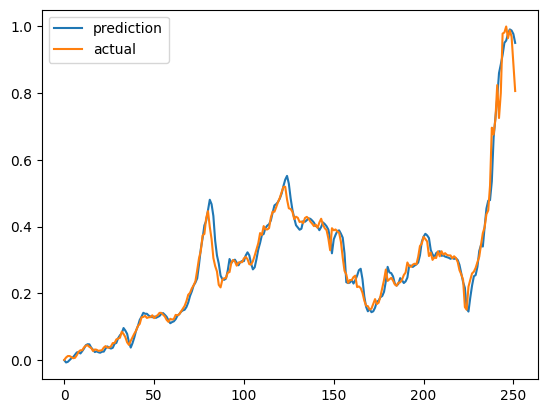

In [382]:
plt.plot(preds, label="prediction")
plt.plot(dataset.data[step:], label="actual")
plt.legend()
plt.show()


In [383]:
dataset[0][0]


tensor([0.0314, 0.0297, 0.0356, 0.0296, 0.0290, 0.0263, 0.0286, 0.0286, 0.0328,
        0.0261, 0.0113, 0.0045])

In [384]:
torch.cat((dataset[0][0], dataset[1][0]))


tensor([0.0314, 0.0297, 0.0356, 0.0296, 0.0290, 0.0263, 0.0286, 0.0286, 0.0328,
        0.0261, 0.0113, 0.0045, 0.0297, 0.0356, 0.0296, 0.0290, 0.0263, 0.0286,
        0.0286, 0.0328, 0.0261, 0.0113, 0.0045, 0.0000])

In [385]:
preds = []  # 예측값들을 저장하는 리스트
pred_model = torch.load("fuel_price_model_r2.pth")
start = dataset[0][0]
with torch.no_grad():
    for i in range(250):
        pred = pred_model(start.unsqueeze(0))
        start = torch.cat((start[1:], pred))
        preds.append(pred.item())


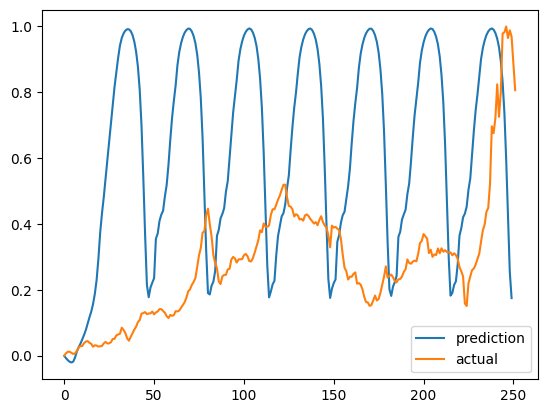

In [386]:
plt.plot(preds, label="prediction")
plt.plot(dataset.data[step:], label="actual")
plt.legend()
plt.show()
